In [2]:
!nvidia-smi

Sat Jul 17 12:30:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   54C    P2    41W / 215W |   2157MiB /  7979MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 2070    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   

In [1]:
import math
import os
import pickle
import pandas as pd
import torch
from torch import nn
from torch.nn.modules.activation import Sigmoid
import torch.utils.data as Data
from propy import AAIndex as AAI
import random
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import functional as F

In [2]:
# basic

ARRAY = 'ARNDCQEGHILKMFPSTWYV'
pro_lays = [
    "ANDN920101", "ARGP820101", "ARGP820102", "ARGP820103", "BEGF750101",
    "BEGF750102", "BEGF750103", "BHAR880101"
]
device = torch.device("cuda:1")
best_loss = -10
divide_size = 10


## Preprocess the Data, get PSSM, AAIndex, One-hot
The tool to get pssm is blast-2.11.0+, the root should be changed.   
Here we show a win10 environment method

In [2]:
def command_pssm(content, pssm_file):
    os.system('F:/blast-2.11.0+/bin/psiblast.exe \
        -db F:/blast-2.11.0+/bin/swissprot/swissprot \
            -query %s -evalue 0.001 \
                -num_iterations 3 \
                    -out_ascii_pssm %s' %(content, pssm_file))
  

In [ ]:
# Three csvs are given. We upload them and delete samples whose experiment data is empty.  
data = "data/sum_pro_data2.csv"
rowfile = pd.read_csv(data)
data = rowfile.to_numpy()
pro_data = []
for datalist in data:
    genlist = list("YSALM*KVVADGTLKVKF*I*EPALA")
    genlist[5],genlist[18], genlist[20] = datalist[0],datalist[1],datalist[2] 
    ee = (datalist[3]-datalist[4])/100
    prolist = "".join(genlist)
    ee = float(ee)
    pro_data.append({"array":prolist, "ee":ee})
    # pro_data.append([prolist,ee])


In [ ]:
# Get PSSM, AAIndex, One-hot and save them in the dict.
for eachdata in pro_data:
    pro_list = eachdata["array"]
    with open("0.fasta", "wt") as f:
        f.write(">\n")
        f.write(pro_list)
    command_pssm("0.fasta","0.pssm")
    with open("0.pssm","rt") as f:
        readline = [eachline.split() for eachline in f]
        data = readline[3:]
    data = [eachline[2:22] for eachline in data][:len(pro_list)]
    for each in range(len(pro_list)):
        for ach in range(20):
            data[each][ach] = int(data[each][ach])
    eachdata["pssm"] = data

    pro_list = eachdata["array"]
    one_hot = [[int(pro == sta) for sta in ARRAY]for pro in pro_list]
    
    eachdata["one_hot"] = one_hot

    aaindex = [[ AAI.GetAAIndex1(each_prop)[amino] for each_prop in pro_lays] for amino in eachdata["array"]] 
    eachdata["AAIndex"] = aaindex
   

In [ ]:
# save the prodatasets.
if not os.path.isdir('processed/data'):
    os.makedirs('processed/data')
    
with open("processed/data/pro_data.pkl","wb") as f:
    pickle.dump(pro_data, f)

## Set the Model

In [138]:
# draw the loss-epoch graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def LearningCurve(epoch, train_loss, val_loss, title='Learning Curve', figure_file=None):
    sns.set(style='whitegrid', palette='muted', color_codes=True)
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    plt.plot(epoch, train_loss,  color='blue', label="Training Loss")
    plt.plot(epoch, val_loss,  color='green', label="Validation Loss")
    plt.tick_params(axis='both', which='major', labelsize=18)
    if title:
        plt.title(label=title, fontsize=28)
    plt.xlabel(xlabel=r'Epoch', fontsize=24)
    plt.ylabel(ylabel=r'Loss', fontsize=24)
    
    #plt.subplots_adjust(wspace =0.3, hspace =0.3)#调整子图间距
    plt.legend(fontsize=18, loc='best')
    if figure_file != None:
        plt.savefig(figure_file, dpi=300)
    plt.show()


In [334]:
# prediction and validation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def Plot_True_vs_Pred(y_true, y_pred, title='Pred vs. True', low=None, up=None, loc=None, figure_file=None):
    sns.set(style='whitegrid', palette='muted', color_codes=True)
    low = low if low!=None else min(y_true.min(), y_pred.min())-0.2
    up = up if up!=None else max(y_true.max(), y_pred.max())+0.2
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    plt.scatter(y_true, y_pred,  color='green')
    plt.plot((low,up), (low,up), color='blue', linewidth=3)
    plt.tick_params(axis='both', which='major', labelsize=18)
    if title:
        plt.title(label=title, fontsize=28)
    plt.xlabel(xlabel=r'ee of Experiment', fontsize=24)
    plt.ylabel(ylabel=r'ee of Prediction', fontsize=24)
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    if not loc:
        plt.text((low+up)/2+0.3, low+0.1, s='R$^2$ = %.3f\nMAE = %.2f\nMSE = %.2f\n'%(R2, MAE, MSE),
            fontdict={'size': '20', 'color': 'black'})
    else:
        plt.text(loc[0], loc[1], s='R$^2$ = %.3f\nMAE = %.2f\nMSE = %.2f\n'%(R2, MAE, MSE),
            fontdict={'size': '20', 'color': 'black'})
    #plt.subplots_adjust(wspace =0.3, hspace =0.3)#调整子图间距
    if figure_file != None:
        plt.savefig(figure_file, dpi=300)
    plt.show()


In [140]:
# function of loading saved model

def load_checkpoint(model, optimizer, history, filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        history = checkpoint['history']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, history


In [224]:
# Define model training and test logic

#import time
import torch.nn.functional as F

def run_epoch(data_iter, model, optimizer, device, train=False):
    "Standard Training and Logging Function"
    #start = time.time()
    total_samples = 0
    total_loss = 0
    #n_samples = 0
    #last_batch_num = len(data_iter)//data_iter.batch_size
    if not train:
        model.eval()
    if device:
        model.to(device)
    sum_loss = 0
    print_size = 1
    for i, (X, ee) in enumerate(data_iter):
        if device:
            sum_data.to(device)
            ee.to(device)
        _num = len(ee)
        if train:
            optimizer.zero_grad()
            out = model(X).squeeze(1)
            loss = F.mse_loss(out, ee)
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                out = model.forward(X)
            loss = F.mse_loss(out, ee)
        
        total_loss += loss * _num
        total_samples += _num
        sum_loss += loss
        if i % print_size == 0:
            print("step: %d, loss = %.10f" % (i, sum_loss / print_size),end="\r")
            sum_loss = 0
        #n_samples += _num
        #if i > 0 and i % 2 == 0 or i == last_batch_num-1:
        #    elapsed = time.time() - start
        #    print("    **Epoch Step: %d Loss: %.4f RMSE: %.4f samples per Sec: %.4f" %
        #          (i, loss, torch.sqrt(loss), n_samples / elapsed))
        #    start = time.time()
        #    n_samples = 0
    return total_loss / total_samples

In [142]:
# Get the predicted value
from tqdm.notebook import tqdm

def get_prediction(model, data_iter, mode='predict', device=None):
    '''
    mode: 'predict' or 'evaluate'
    '''
    assert mode in ['predict', 'evaluate'], "mode should be 'predict' or 'evaluate'"
    if device:
        model.to(device)
    model.eval()
    if mode == 'evaluate':
        ys_true = torch.ones((0,1))
        ys_pred = torch.ones((0,1)) 
        with torch.no_grad():
            for (X, ee_true) in tqdm(data_iter):
                ee_true = ee_true.unsqueeze(1).cpu()
                ee_pred = model(X).cpu()
                ys_pred = torch.cat((ys_pred, ee_pred), dim=0)
                ys_true = torch.cat((ys_true, ee_true), dim=0)
        return ys_pred, ys_true
    else:
        ys_pred = torch.ones((0,1))
        with torch.no_grad():
            for (it,X) in tqdm(data_iter): # !!!!! 
                it = it.unsqueeze(1).cpu()
                ee_pred = model(X).cpu()
                ys_pred = torch.cat((ys_pred, ee_pred), dim=0)
        return ys_pred

In [413]:
# Load data for training and analysis
# Random split the data into train/valid/test with 126/32/32 samples

def data_process(model_label = "cnn", charactor = "sequence", desc_flag='all', data_dir = "processed/data"):
    # Random shift the data and cut the dataset
    test_size = 32 # The size of test_data and val_data
    with open("%s/pro_data.pkl" % data_dir, "rb") as f:
        all_data = pickle.load(f)
    random.shuffle(all_data)
    test_data = all_data[:test_size]   # [:32]
    val_data = all_data[test_size: 2 * test_size] # [32:64]
    train_data = all_data[2 * test_size:] # [64:]
    
    # collect the charactor and build the matrix for training
    for process_data in (train_data, val_data, test_data):
        for it, data in enumerate(process_data):
            pssm = torch.tensor(data["pssm"])
            one_hot =  torch.tensor(data["one_hot"])
            aaindex =torch.tensor(data["AAIndex"])
            if desc_flag=='all':
                sum_data = torch.cat((pssm, aaindex, one_hot),1).to(device)
            elif desc_flag=='pssm':
                sum_data = pssm.float().to(device)
            elif desc_flag=='one_hot':
                sum_data = one_hot.float().to(device)
            elif desc_flag=='AAIndex':
                sum_data = aaindex.float().to(device)
            else:
                assert desc_flag in ['all', 'pssm', 'one_hot', 'AAIndex'], "the value of desc_flag is wrong"
            # sum_data = (one_hot + 0.0).to(device)  
            if charactor == "3amino":
                tem = torch.cat(
                    (sum_data[5].unsqueeze(0), sum_data[18].unsqueeze(0),
                     sum_data[20].unsqueeze(0)), 0)
                sum_data = tem.to(device)
            if model_label == "cnn":
                sum_data = sum_data.unsqueeze(0)
            ee = data["ee"]
            process_data[it] = ((sum_data, torch.tensor(ee).to(device)))

    batch_size=32
    train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = Data.DataLoader(dataset=test_data, batch_size=batch_size)
    val_loader = Data.DataLoader(dataset=val_data, batch_size=batch_size)
    return train_loader, test_loader, val_loader

In [414]:
# Load the data for prediction

def pred_process(model_label = "cnn", charactor = "sequence", desc_flag='all', data_dir = "processed/data"):
    with open("%s/exam_data.pkl" % data_dir, "rb") as f:
        pred_data = pickle.load(f)
    for it, data in enumerate(pred_data):
        pssm = torch.tensor(data["pssm"])
        one_hot =  torch.tensor(data["one_hot"])
        aaindex =torch.tensor(data["AAIndex"])
        if desc_flag=='all':
            sum_data = torch.cat((pssm, aaindex, one_hot),1).to(device)
        elif desc_flag=='pssm':
            sum_data = pssm.float().to(device)
        elif desc_flag=='one_hot':
            sum_data = one_hot.float().to(device)
        elif desc_flag=='AAIndex':
            sum_data = aaindex.float().to(device)
        else:
            assert desc_flag in ['all', 'pssm', 'one_hot', 'AAIndex'], "the value of desc_flag is wrong"
        # sum_data = (one_hot + 0.0).unsqueeze(0).to(device)  
        if charactor == "3amino":
            tem = torch.cat(
                (sum_data[5].unsqueeze(0), sum_data[18].unsqueeze(0),
                 sum_data[20].unsqueeze(0)), 0)
            sum_data = tem.to(device)
        if model_label == "cnn":
            sum_data = sum_data.unsqueeze(0)
        pred_data[it] = ((torch.tensor(it).to(device),sum_data))

    batch_size=32
    pred_loader = Data.DataLoader(dataset=pred_data, batch_size=batch_size)
    return pred_loader

In [406]:
# define the Model(CNN & LSTM)

class CNN(nn.Module):
    def __init__(
        self,
        conv_out_len,
        hidden=32,
    ):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=2),
            nn.BatchNorm2d(3),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        '''self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2))'''
        #self.lin = nn.Sequential(nn.Linear(conv_out_len,hidden),nn.BatchNorm1d(hidden),nn.ReLU(),nn.Linear(hidden,1))
        self.lin = nn.Sequential(nn.Linear(conv_out_len,hidden),nn.ReLU(),nn.Linear(hidden,1))

    def forward(self, x):
        x = self.conv1(x)
        # x = self.conv2(x)
        x = x.view(x.size(0), -1)
        try:
            x = self.lin(x)
        except:
            print(x.size())
        return x


class LSTM(nn.Module):
    def __init__(self, input_size, hidden=64):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden,
                            num_layers=1,
                            batch_first=True)
        #self.lin = nn.Linear(hidden, 1)
        #self.lin = nn.Sequential(nn.Linear(hidden,32),nn.BatchNorm1d(32),nn.ReLU(),nn.Linear(32,1))
        self.lin = nn.Sequential(nn.Linear(hidden,32),nn.BatchNorm1d(32),nn.ReLU(),
                                 nn.Linear(32,16),nn.ReLU(),
                                 nn.Linear(16,1))

    def forward(self, x):
        result, _ = self.lstm(x, None)
        result = self.lin(result[:, -1, :])
        return result

In [346]:
# global variable to store top50 prediction
predict_dfs = {}


### cnn (sequence, all)

In [313]:
# Initialization parameters and generate train/val/test data
model_label = "cnn" # "lstm"
charactor = "sequence"
desc_flag='all'
history = dict()
save_dir = r'processed/models' # the folder for saving trained models
data_dir = r"processed/data" # the folder for source file with pmms/one-hot/aaindex data
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

PATH = r'%s/pro_%s_%s_%s'%(save_dir,model_label,charactor,desc_flag)

train_loader, test_loader, val_loader = data_process(model_label, charactor, desc_flag, data_dir)
input_size=train_loader.dataset[0][0].shape[-1]
if model_label == "cnn":
    model = CNN(conv_out_len=1050, hidden=32)
elif model_label == "lstm":
    model = LSTM(input_size=input_size, hidden=32)
device = torch.device("cuda:0")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)

PATH_train_best = r'%s_train_best.pt' % (PATH)
PATH_val_best = r'%s_val_best.pt' % (PATH)
min_train_loss, min_val_loss = 1, 1

In [318]:
# Start training
lr = 0.0001
if True:
    epoches = 1000
    pre_epoch = len(history)
    for epoch in range(epoches):
        lr = lr*0.995**(epoch//5)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        _epoch = pre_epoch+epoch+1
        if _epoch % 40000 == 0:
            scheduler.step()
            print("learning_rate: %.10f" % scheduler.get_lr()[0])
        model.train()
        train_loss = run_epoch(train_loader, model, optimizer, device, train=True)
        print("Eopch %4d: Total train_MSE: %.6f Total train_RMSE: %.6f"%(_epoch, train_loss, torch.sqrt(train_loss)))
        model.eval()
        val_loss = run_epoch(val_loader, model, None, device)
        print("Eopch %4d: Total val_MSE: %.6f Total val_RMSE: %.6f"%(_epoch, val_loss, torch.sqrt(val_loss)))
        history[_epoch] = {'train_loss': train_loss, 'val_loss': val_loss}
        
        if train_loss <= min_train_loss:
            min_train_loss = train_loss
            state_train_best = {'epoch': _epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'history': history, }
            torch.save(state_train_best, PATH_train_best)
        
        if val_loss <= min_val_loss:
            min_val_loss = val_loss
            state_val_best = {'epoch': _epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'history': history, }
            torch.save(state_val_best, PATH_val_best)

Eopch 1001: Total train_MSE: 0.087643 Total train_RMSE: 0.296046
Eopch 1001: Total val_MSE: 0.049100 Total val_RMSE: 0.221586
Eopch 1002: Total train_MSE: 0.084862 Total train_RMSE: 0.291311
Eopch 1002: Total val_MSE: 0.048675 Total val_RMSE: 0.220624
Eopch 1003: Total train_MSE: 0.086101 Total train_RMSE: 0.293429
Eopch 1003: Total val_MSE: 0.048787 Total val_RMSE: 0.220878
Eopch 1004: Total train_MSE: 0.084949 Total train_RMSE: 0.291460
Eopch 1004: Total val_MSE: 0.048685 Total val_RMSE: 0.220647
Eopch 1005: Total train_MSE: 0.085463 Total train_RMSE: 0.292340
Eopch 1005: Total val_MSE: 0.048770 Total val_RMSE: 0.220839
Eopch 1006: Total train_MSE: 0.084798 Total train_RMSE: 0.291201
Eopch 1006: Total val_MSE: 0.048752 Total val_RMSE: 0.220798
Eopch 1007: Total train_MSE: 0.084963 Total train_RMSE: 0.291484
Eopch 1007: Total val_MSE: 0.048809 Total val_RMSE: 0.220928
Eopch 1008: Total train_MSE: 0.084558 Total train_RMSE: 0.290788
Eopch 1008: Total val_MSE: 0.048804 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch 1024: Total train_MSE: 0.081507 Total train_RMSE: 0.285495
Eopch 1024: Total val_MSE: 0.049268 Total val_RMSE: 0.221964
Eopch 1025: Total train_MSE: 0.081496 Total train_RMSE: 0.285475
Eopch 1025: Total val_MSE: 0.049255 Total val_RMSE: 0.221935
Eopch 1026: Total train_MSE: 0.081079 Total train_RMSE: 0.284744
Eopch 1026: Total val_MSE: 0.049344 Total val_RMSE: 0.222134
Eopch 1027: Total train_MSE: 0.081124 Total train_RMSE: 0.284822
Eopch 1027: Total val_MSE: 0.049318 Total val_RMSE: 0.222077
Eopch 1028: Total train_MSE: 0.080711 Total train_RMSE: 0.284096
Eopch 1028: Total val_MSE: 0.049398 Total val_RMSE: 0.222257
Eopch 1029: Total train_MSE: 0.080718 Total train_RMSE: 0.284109
Eopch 1029: Total val_MSE: 0.049377 Total val_RMSE: 0.222209
Eopch 1030: Total train_MSE: 0.080364 Total train_RMSE: 0.283485
Eopch 1030: Total val_MSE: 0.049417 Total val_RMSE: 0.222300
Eopch 1031: Total train_MSE: 0.080245 Total train_RMSE: 0.283275
Eopch 1031: Total val_MSE: 0.049469 Total val_RMSE: 0

Eopch 1090: Total val_MSE: 0.050793 Total val_RMSE: 0.225373
Eopch 1091: Total train_MSE: 0.075208 Total train_RMSE: 0.274241
Eopch 1091: Total val_MSE: 0.050793 Total val_RMSE: 0.225373
Eopch 1092: Total train_MSE: 0.075197 Total train_RMSE: 0.274221
Eopch 1092: Total val_MSE: 0.050798 Total val_RMSE: 0.225384
Eopch 1093: Total train_MSE: 0.075189 Total train_RMSE: 0.274207
Eopch 1093: Total val_MSE: 0.050800 Total val_RMSE: 0.225389
Eopch 1094: Total train_MSE: 0.075181 Total train_RMSE: 0.274191
Eopch 1094: Total val_MSE: 0.050804 Total val_RMSE: 0.225398
Eopch 1095: Total train_MSE: 0.075174 Total train_RMSE: 0.274179
Eopch 1095: Total val_MSE: 0.050805 Total val_RMSE: 0.225399
Eopch 1096: Total train_MSE: 0.075167 Total train_RMSE: 0.274167
Eopch 1096: Total val_MSE: 0.050806 Total val_RMSE: 0.225402
Eopch 1097: Total train_MSE: 0.075160 Total train_RMSE: 0.274154
Eopch 1097: Total val_MSE: 0.050809 Total val_RMSE: 0.225409
Eopch 1098: Total train_MSE: 0.075154 Total train_RMSE: 0

Eopch 1158: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1158: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1159: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1159: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1160: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1160: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1161: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1161: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1162: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1162: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1163: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1163: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1164: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1164: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1165: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1165: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1225: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1225: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1226: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1226: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1227: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1227: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1228: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1228: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1229: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1229: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1230: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1230: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1231: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1231: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1232: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1232: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1291: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1291: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1292: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1292: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1293: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1293: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1294: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1294: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1295: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1295: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1296: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1296: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1297: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1297: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1298: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1298: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1359: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1359: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1360: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1360: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1361: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1361: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1362: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1362: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1363: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1363: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1364: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1364: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1365: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1365: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1366: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1366: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1425: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1425: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1426: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1426: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1427: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1427: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1428: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1428: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1429: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1429: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1430: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1430: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1431: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1431: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1432: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1432: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1492: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1492: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1493: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1493: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1494: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1494: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1495: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1495: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1496: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1496: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1497: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1497: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1498: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1498: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1499: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1499: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1558: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1558: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1559: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1559: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1560: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1560: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1561: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1561: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1562: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1562: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1563: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1563: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1564: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1564: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1565: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1565: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1625: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1625: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1626: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1626: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1627: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1627: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1628: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1628: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1629: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1629: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1630: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1630: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1631: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1631: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1632: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1632: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1691: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1692: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1692: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1693: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1693: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1694: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1694: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1695: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1695: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1696: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1696: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1697: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1697: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1698: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1698: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1699: Total train_MSE: 0.075099 Total train_RMSE: 0

Eopch 1758: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1758: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1759: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1759: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1760: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1760: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1761: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1761: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1762: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1762: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1763: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1763: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1764: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1764: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1765: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1765: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1824: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1824: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1825: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1825: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1826: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1826: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1827: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1827: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1828: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1828: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1829: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1829: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1830: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1830: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1831: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1831: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1890: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1890: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1891: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1891: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1892: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1892: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1893: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1893: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1894: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1894: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1895: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1895: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1896: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1896: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1897: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1897: Total val_MSE: 0.050828 Total val_RMSE: 0

Eopch 1957: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1957: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1958: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1958: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1959: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1959: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1960: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1960: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1961: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1961: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1962: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1962: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1963: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1963: Total val_MSE: 0.050828 Total val_RMSE: 0.225452
Eopch 1964: Total train_MSE: 0.075099 Total train_RMSE: 0.274042
Eopch 1964: Total val_MSE: 0.050828 Total val_RMSE: 0

In [148]:
# Save the current training step model
state = {'epoch': _epoch, 'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(), 'history': history, }
torch.save(state, PATH)

In [ ]:
# Load the saved model. It's useless and needs to be run by copying to a new cell
model_s, model_opt.optimizer, pre_epoch, history = load_checkpoint(model, model_opt.optimizer, history, filename=PATH)
#device = torch.device("cuda:0")
model_s.to(device).eval()
pre_epoch

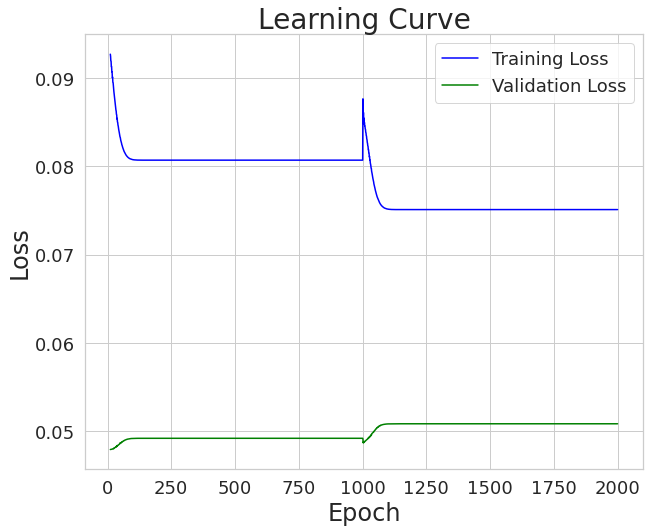

In [319]:
# Draw the Training curve
history = history
epoch_np = np.arange(11, len(history))
train_loss_np, val_loss_np = [], []
for i in epoch_np:
    train_loss_np.append(float(history[i]['train_loss']))
    val_loss_np.append(float(history[i]['val_loss']))
train_loss_np = np.array(train_loss_np)
val_loss_np = np.array(val_loss_np)

LearningCurve(epoch_np, train_loss_np, val_loss_np)

  0%|          | 0/1 [00:00<?, ?it/s]

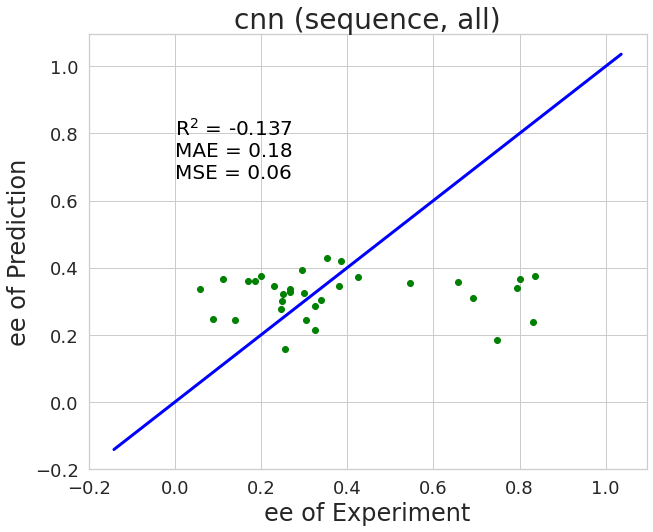

In [345]:
# True vs Pred
ys_pred, ys_true = get_prediction(model, test_loader, mode='evaluate', device=device)
Plot_True_vs_Pred(ys_true, ys_pred, loc=(0.0, 0.6), title='{} ({}, {})'.format(model_label, charactor, desc_flag))

In [347]:
# Predicting unknown sequences: top50
pred_loader = pred_process(model_label, charactor, desc_flag, data_dir)
ys_pred = get_prediction(model, pred_loader, mode='predict', device=device)
ys_pred = sorted([[ee, i] for i, ee in enumerate(ys_pred)], reverse=True)
ys_choose = [(i, ee) for ee, i in ys_pred[:50]]
with open("%s/exam_data.pkl" % data_dir, "rb") as f:
    pred_data = pickle.load(f)
protein_list = [[''.join([pred_data[it]["array"][5], pred_data[it]["array"][18],
                          pred_data[it]["array"][20]]), np.round(ee.item(), 4)] for it, ee in ys_choose]
print(protein_list)
protein_df = pd.DataFrame(np.array(protein_list), columns=['seq', 'ee'])
predict_dfs['{} ({}, {})'.format(model_label, charactor, desc_flag)] = protein_df

  0%|          | 0/250 [00:00<?, ?it/s]

[['VSG', 0.5674], ['RSG', 0.5632], ['VWG', 0.559], ['KSG', 0.5545], ['VTG', 0.5506], ['VSH', 0.5471], ['ESG', 0.544], ['VPG', 0.5421], ['ASG', 0.5388], ['VSA', 0.5387], ['TSG', 0.5378], ['VHG', 0.5353], ['VDG', 0.535], ['SSG', 0.5348], ['RWG', 0.5339], ['VSP', 0.5331], ['VSS', 0.5327], ['RTG', 0.529], ['QSG', 0.5281], ['PSG', 0.5277], ['VSN', 0.5269], ['VHH', 0.5264], ['ISG', 0.5258], ['VST', 0.5242], ['DSG', 0.522], ['RPG', 0.5208], ['KTG', 0.5203], ['KWG', 0.5202], ['RSA', 0.519], ['RSH', 0.5188], ['IWG', 0.5183], ['VWH', 0.5179], ['VSC', 0.5141], ['VWA', 0.5139], ['VEG', 0.5133], ['VYG', 0.5129], ['RHG', 0.5119], ['VVG', 0.5116], ['VGG', 0.511], ['VTP', 0.5109], ['RSS', 0.5105], ['VTS', 0.5098], ['TWG', 0.5096], ['VNG', 0.5092], ['AWG', 0.5092], ['KSH', 0.5091], ['ETG', 0.5088], ['VSQ', 0.5086], ['VWC', 0.5081], ['KPG', 0.5078]]


## other models

In [376]:
def process(model_label, charactor, desc_flag, predict_dfs, conv_out_len):
    history = dict()
    save_dir = r'processed/models' # the folder for saving trained models
    data_dir = r"processed/data" # the folder for source file with pmms/one-hot/aaindex data
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    PATH = r'%s/pro_%s_%s_%s'%(save_dir,model_label,charactor,desc_flag)
    
    train_loader, test_loader, val_loader = data_process(model_label, charactor, desc_flag, data_dir)
    input_size=train_loader.dataset[0][0].shape[-1]
    if model_label == "cnn":
        model = CNN(conv_out_len=conv_out_len, hidden=32)
    elif model_label == "lstm":
        model = LSTM(input_size=input_size, hidden=64)
    device = torch.device("cuda:0")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)
    
    PATH_train_best = r'%s_train_best.pt' % (PATH)
    PATH_val_best = r'%s_val_best.pt' % (PATH)
    min_train_loss, min_val_loss = 1, 1
    
    ## start training
    lr = 0.0001
    epoches = 1000
    pre_epoch = len(history)
    for epoch in range(epoches):
        lr = lr*0.995**(epoch//5)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        _epoch = pre_epoch+epoch+1
        if _epoch % 40000 == 0:
            scheduler.step()
            print("learning_rate: %.10f" % scheduler.get_lr()[0])
        model.train()
        train_loss = run_epoch(train_loader, model, optimizer, device, train=True)
        print("Eopch %4d: Total train_MSE: %.6f Total train_RMSE: %.6f"%(_epoch, train_loss, torch.sqrt(train_loss)))
        model.eval()
        val_loss = run_epoch(val_loader, model, None, device)
        print("Eopch %4d: Total val_MSE: %.6f Total val_RMSE: %.6f"%(_epoch, val_loss, torch.sqrt(val_loss)))
        history[_epoch] = {'train_loss': train_loss, 'val_loss': val_loss}
        
        if train_loss <= min_train_loss:
            min_train_loss = train_loss
            state_train_best = {'epoch': _epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'history': history, }
            torch.save(state_train_best, PATH_train_best)
        
        if val_loss <= min_val_loss:
            min_val_loss = val_loss
            state_val_best = {'epoch': _epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'history': history, }
            torch.save(state_val_best, PATH_val_best)
    
    # save model
    state = {'epoch': _epoch, 'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(), 'history': history, }
    torch.save(state, PATH)
    
    # plot Learning Curve
    history = history
    epoch_np = np.arange(11, len(history))
    train_loss_np, val_loss_np = [], []
    for i in epoch_np:
        train_loss_np.append(float(history[i]['train_loss']))
        val_loss_np.append(float(history[i]['val_loss']))
    train_loss_np = np.array(train_loss_np)
    val_loss_np = np.array(val_loss_np)
    
    LearningCurve(epoch_np, train_loss_np, val_loss_np)
    
    ## True vs Pred
    ys_pred, ys_true = get_prediction(model, test_loader, mode='evaluate', device=device)
    Plot_True_vs_Pred(ys_true, ys_pred, loc=(0.0, 0.6), title='{} ({}, {})'.format(model_label, charactor, desc_flag))
    
    # predict seq
    pred_loader = pred_process(model_label, charactor, desc_flag, data_dir)
    ys_pred = get_prediction(model, pred_loader, mode='predict', device=device)
    ys_pred = sorted([[ee, i] for i, ee in enumerate(ys_pred)], reverse=True)
    ys_choose = [(i, ee) for ee, i in ys_pred[:50]]
    with open("%s/exam_data.pkl" % data_dir, "rb") as f:
        pred_data = pickle.load(f)
    protein_list = [[''.join([pred_data[it]["array"][5], pred_data[it]["array"][18],
                              pred_data[it]["array"][20]]), np.round(ee.item(), 4)] for it, ee in ys_choose]
    print(protein_list)
    protein_df = pd.DataFrame(np.array(protein_list), columns=['seq', 'ee'])
    predict_dfs['{} ({}, {})'.format(model_label, charactor, desc_flag)] = protein_df
    
    return predict_dfs

### desc_flag='all'

Eopch    1: Total train_MSE: 0.077114 Total train_RMSE: 0.277694
Eopch    1: Total val_MSE: 0.115013 Total val_RMSE: 0.339136
Eopch    2: Total train_MSE: 0.071675 Total train_RMSE: 0.267721
Eopch    2: Total val_MSE: 0.117445 Total val_RMSE: 0.342703
Eopch    3: Total train_MSE: 0.070022 Total train_RMSE: 0.264617
Eopch    3: Total val_MSE: 0.118803 Total val_RMSE: 0.344677
Eopch    4: Total train_MSE: 0.068830 Total train_RMSE: 0.262354
Eopch    4: Total val_MSE: 0.119618 Total val_RMSE: 0.345858
Eopch    5: Total train_MSE: 0.067740 Total train_RMSE: 0.260269
Eopch    5: Total val_MSE: 0.120378 Total val_RMSE: 0.346955
Eopch    6: Total train_MSE: 0.066737 Total train_RMSE: 0.258334
Eopch    6: Total val_MSE: 0.120888 Total val_RMSE: 0.347690
Eopch    7: Total train_MSE: 0.065782 Total train_RMSE: 0.256479
Eopch    7: Total val_MSE: 0.121327 Total val_RMSE: 0.348320
Eopch    8: Total train_MSE: 0.064905 Total train_RMSE: 0.254764
Eopch    8: Total val_MSE: 0.121672 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   21: Total train_MSE: 0.058041 Total train_RMSE: 0.240916
Eopch   21: Total val_MSE: 0.124791 Total val_RMSE: 0.353257
Eopch   22: Total train_MSE: 0.057714 Total train_RMSE: 0.240237
Eopch   22: Total val_MSE: 0.124903 Total val_RMSE: 0.353417
Eopch   23: Total train_MSE: 0.057418 Total train_RMSE: 0.239620
Eopch   23: Total val_MSE: 0.125113 Total val_RMSE: 0.353713
Eopch   24: Total train_MSE: 0.057108 Total train_RMSE: 0.238973
Eopch   24: Total val_MSE: 0.125212 Total val_RMSE: 0.353853
Eopch   25: Total train_MSE: 0.056799 Total train_RMSE: 0.238326
Eopch   25: Total val_MSE: 0.125349 Total val_RMSE: 0.354046
Eopch   26: Total train_MSE: 0.056555 Total train_RMSE: 0.237814
Eopch   26: Total val_MSE: 0.125550 Total val_RMSE: 0.354330
Eopch   27: Total train_MSE: 0.056293 Total train_RMSE: 0.237261
Eopch   27: Total val_MSE: 0.125688 Total val_RMSE: 0.354524
Eopch   28: Total train_MSE: 0.056072 Total train_RMSE: 0.236795
Eopch   28: Total val_MSE: 0.125922 Total val_RMSE: 0

Eopch   88: Total train_MSE: 0.051363 Total train_RMSE: 0.226633
Eopch   88: Total val_MSE: 0.128618 Total val_RMSE: 0.358633
Eopch   89: Total train_MSE: 0.051356 Total train_RMSE: 0.226618
Eopch   89: Total val_MSE: 0.128623 Total val_RMSE: 0.358641
Eopch   90: Total train_MSE: 0.051349 Total train_RMSE: 0.226602
Eopch   90: Total val_MSE: 0.128628 Total val_RMSE: 0.358647
Eopch   91: Total train_MSE: 0.051342 Total train_RMSE: 0.226588
Eopch   91: Total val_MSE: 0.128630 Total val_RMSE: 0.358650
Eopch   92: Total train_MSE: 0.051337 Total train_RMSE: 0.226576
Eopch   92: Total val_MSE: 0.128636 Total val_RMSE: 0.358658
Eopch   93: Total train_MSE: 0.051331 Total train_RMSE: 0.226563
Eopch   93: Total val_MSE: 0.128637 Total val_RMSE: 0.358660
Eopch   94: Total train_MSE: 0.051326 Total train_RMSE: 0.226553
Eopch   94: Total val_MSE: 0.128643 Total val_RMSE: 0.358669
Eopch   95: Total train_MSE: 0.051322 Total train_RMSE: 0.226543
Eopch   95: Total val_MSE: 0.128644 Total val_RMSE: 0

Eopch  155: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  155: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  156: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  156: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  157: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  157: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  158: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  158: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  159: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  159: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  160: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  160: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  161: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  161: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  162: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  162: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  223: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  223: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  224: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  224: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  225: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  225: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  226: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  226: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  227: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  227: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  228: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  228: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  229: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  229: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  230: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  230: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  295: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  295: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  296: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  296: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  297: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  297: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  298: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  298: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  299: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  299: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  300: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  300: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  301: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  301: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  302: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  302: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  367: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  367: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  368: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  368: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  369: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  369: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  370: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  370: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  371: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  371: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  372: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  372: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  373: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  373: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  374: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  374: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  439: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  440: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  440: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  441: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  441: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  442: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  442: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  443: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  443: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  444: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  444: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  445: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  445: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  446: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  446: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  447: Total train_MSE: 0.051281 Total train_RMSE: 0

Eopch  511: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  511: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  512: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  512: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  513: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  513: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  514: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  514: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  515: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  515: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  516: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  516: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  517: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  517: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  518: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  518: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  583: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  583: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  584: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  584: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  585: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  585: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  586: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  586: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  587: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  587: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  588: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  588: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  589: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  589: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  590: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  590: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  655: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  655: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  656: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  656: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  657: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  657: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  658: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  658: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  659: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  659: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  660: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  660: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  661: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  661: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  662: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  662: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  727: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  727: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  728: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  728: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  729: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  729: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  730: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  730: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  731: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  731: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  732: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  732: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  733: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  733: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  734: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  734: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  799: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  799: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  800: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  800: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  801: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  801: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  802: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  802: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  803: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  803: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  804: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  804: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  805: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  805: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  806: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  806: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  871: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  871: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  872: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  872: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  873: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  873: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  874: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  874: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  875: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  875: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  876: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  876: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  877: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  877: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  878: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  878: Total val_MSE: 0.128672 Total val_RMSE: 0

Eopch  943: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  943: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  944: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  944: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  945: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  945: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  946: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  946: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  947: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  947: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  948: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  948: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  949: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  949: Total val_MSE: 0.128672 Total val_RMSE: 0.358709
Eopch  950: Total train_MSE: 0.051281 Total train_RMSE: 0.226453
Eopch  950: Total val_MSE: 0.128672 Total val_RMSE: 0

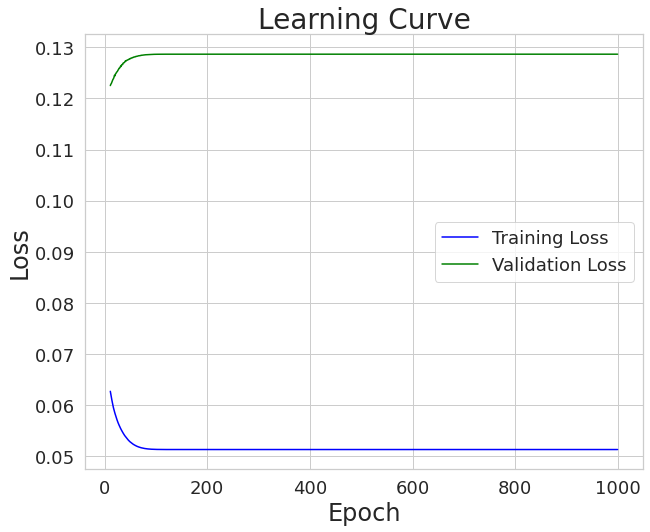

  0%|          | 0/1 [00:00<?, ?it/s]

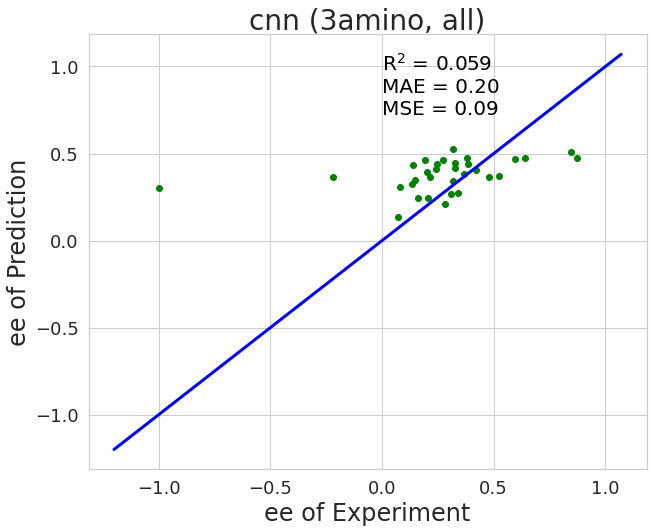

  0%|          | 0/250 [00:00<?, ?it/s]

[['VHC', 0.7081], ['IHC', 0.6669], ['CHC', 0.6604], ['CWC', 0.6419], ['CYC', 0.6383], ['DNC', 0.6336], ['CPC', 0.633], ['VSC', 0.6329], ['THC', 0.6328], ['CSC', 0.632], ['HRC', 0.6282], ['VNC', 0.6238], ['TNC', 0.6234], ['HNC', 0.6231], ['VYC', 0.6202], ['DHC', 0.6198], ['CFC', 0.6196], ['KCH', 0.6182], ['AHC', 0.6161], ['KIH', 0.6115], ['ANC', 0.6103], ['WWC', 0.6101], ['WWT', 0.6089], ['DSC', 0.6083], ['DWN', 0.606], ['DYC', 0.6059], ['KVH', 0.6057], ['CYH', 0.6057], ['CWN', 0.6052], ['DWC', 0.6045], ['CWS', 0.6036], ['CYD', 0.6035], ['CYN', 0.6024], ['RVH', 0.6007], ['KYH', 0.6002], ['VPC', 0.5996], ['KSC', 0.5989], ['HSC', 0.5985], ['AYC', 0.5984], ['SWN', 0.5981], ['TRC', 0.5981], ['VHD', 0.5977], ['RSC', 0.5968], ['VWC', 0.5967], ['KSH', 0.5966], ['RSH', 0.5964], ['ASC', 0.5963], ['DWS', 0.5958], ['AWC', 0.5953], ['SWS', 0.5943]]


In [355]:
model_label = "cnn" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='all' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=150)

Eopch    1: Total train_MSE: 0.246669 Total train_RMSE: 0.496657
Eopch    1: Total val_MSE: 0.164355 Total val_RMSE: 0.405407
Eopch    2: Total train_MSE: 0.200179 Total train_RMSE: 0.447414
Eopch    2: Total val_MSE: 0.164810 Total val_RMSE: 0.405968
Eopch    3: Total train_MSE: 0.174102 Total train_RMSE: 0.417255
Eopch    3: Total val_MSE: 0.171377 Total val_RMSE: 0.413977
Eopch    4: Total train_MSE: 0.158851 Total train_RMSE: 0.398562
Eopch    4: Total val_MSE: 0.178630 Total val_RMSE: 0.422647
Eopch    5: Total train_MSE: 0.146559 Total train_RMSE: 0.382830
Eopch    5: Total val_MSE: 0.187166 Total val_RMSE: 0.432627
Eopch    6: Total train_MSE: 0.134926 Total train_RMSE: 0.367323
Eopch    6: Total val_MSE: 0.196043 Total val_RMSE: 0.442767
Eopch    7: Total train_MSE: 0.128351 Total train_RMSE: 0.358261
Eopch    7: Total val_MSE: 0.204361 Total val_RMSE: 0.452063
Eopch    8: Total train_MSE: 0.119627 Total train_RMSE: 0.345871
Eopch    8: Total val_MSE: 0.213005 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   12: Total train_MSE: 0.104290 Total train_RMSE: 0.322940
Eopch   12: Total val_MSE: 0.237135 Total val_RMSE: 0.486966
Eopch   13: Total train_MSE: 0.097817 Total train_RMSE: 0.312757
Eopch   13: Total val_MSE: 0.241086 Total val_RMSE: 0.491005
Eopch   14: Total train_MSE: 0.098753 Total train_RMSE: 0.314249
Eopch   14: Total val_MSE: 0.238532 Total val_RMSE: 0.488397
Eopch   15: Total train_MSE: 0.088451 Total train_RMSE: 0.297408
Eopch   15: Total val_MSE: 0.238955 Total val_RMSE: 0.488830
Eopch   16: Total train_MSE: 0.090457 Total train_RMSE: 0.300760
Eopch   16: Total val_MSE: 0.234556 Total val_RMSE: 0.484310
Eopch   17: Total train_MSE: 0.081517 Total train_RMSE: 0.285513
Eopch   17: Total val_MSE: 0.222785 Total val_RMSE: 0.472001
Eopch   18: Total train_MSE: 0.084166 Total train_RMSE: 0.290114
Eopch   18: Total val_MSE: 0.215215 Total val_RMSE: 0.463913
Eopch   19: Total train_MSE: 0.075432 Total train_RMSE: 0.274649
Eopch   19: Total val_MSE: 0.207120 Total val_RMSE: 0

Eopch   79: Total train_MSE: 0.041618 Total train_RMSE: 0.204006
Eopch   79: Total val_MSE: 0.147409 Total val_RMSE: 0.383938
Eopch   80: Total train_MSE: 0.041624 Total train_RMSE: 0.204019
Eopch   80: Total val_MSE: 0.147891 Total val_RMSE: 0.384566
Eopch   81: Total train_MSE: 0.041558 Total train_RMSE: 0.203859
Eopch   81: Total val_MSE: 0.147707 Total val_RMSE: 0.384327
Eopch   82: Total train_MSE: 0.041487 Total train_RMSE: 0.203683
Eopch   82: Total val_MSE: 0.147491 Total val_RMSE: 0.384046
Eopch   83: Total train_MSE: 0.041498 Total train_RMSE: 0.203711
Eopch   83: Total val_MSE: 0.147857 Total val_RMSE: 0.384522
Eopch   84: Total train_MSE: 0.041433 Total train_RMSE: 0.203551
Eopch   84: Total val_MSE: 0.147874 Total val_RMSE: 0.384543
Eopch   85: Total train_MSE: 0.041436 Total train_RMSE: 0.203557
Eopch   85: Total val_MSE: 0.147955 Total val_RMSE: 0.384650
Eopch   86: Total train_MSE: 0.041402 Total train_RMSE: 0.203475
Eopch   86: Total val_MSE: 0.147583 Total val_RMSE: 0

Eopch  149: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  149: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  150: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  150: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  151: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  151: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  152: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  152: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  153: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  153: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  154: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  154: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  155: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  155: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  156: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  156: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  280: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  280: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  281: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  281: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  282: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  282: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  283: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  283: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  284: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  284: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  285: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  285: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  286: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  286: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  287: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  287: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  346: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  346: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  347: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  347: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  348: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  348: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  349: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  349: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  350: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  350: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  351: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  351: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  352: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  352: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  353: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  353: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  413: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  413: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  414: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  414: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  415: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  415: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  416: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  416: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  417: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  417: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  418: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  418: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  419: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  419: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  420: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  420: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  479: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  479: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  480: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  480: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  481: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  481: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  482: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  482: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  483: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  483: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  484: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  484: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  485: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  485: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  486: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  486: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  545: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  545: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  546: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  546: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  547: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  547: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  548: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  548: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  549: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  549: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  550: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  550: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  551: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  551: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  552: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  552: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  611: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  611: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  612: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  612: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  613: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  613: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  614: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  614: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  615: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  615: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  616: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  616: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  617: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  617: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  618: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  618: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  677: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  677: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  678: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  678: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  679: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  679: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  680: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  680: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  681: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  681: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  682: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  682: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  683: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  683: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  684: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  684: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  743: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  743: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  744: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  744: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  745: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  745: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  746: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  746: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  747: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  747: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  748: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  748: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  749: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  749: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  750: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  750: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  809: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  809: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  810: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  810: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  811: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  811: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  812: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  812: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  813: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  813: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  814: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  814: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  815: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  815: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  816: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  816: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  875: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  875: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  876: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  876: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  877: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  877: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  878: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  878: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  879: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  879: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  880: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  880: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  881: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  881: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  882: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  882: Total val_MSE: 0.148065 Total val_RMSE: 0

Eopch  941: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  941: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  942: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  942: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  943: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  943: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  944: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  944: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  945: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  945: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  946: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  946: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  947: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  947: Total val_MSE: 0.148065 Total val_RMSE: 0.384792
Eopch  948: Total train_MSE: 0.041117 Total train_RMSE: 0.202774
Eopch  948: Total val_MSE: 0.148065 Total val_RMSE: 0

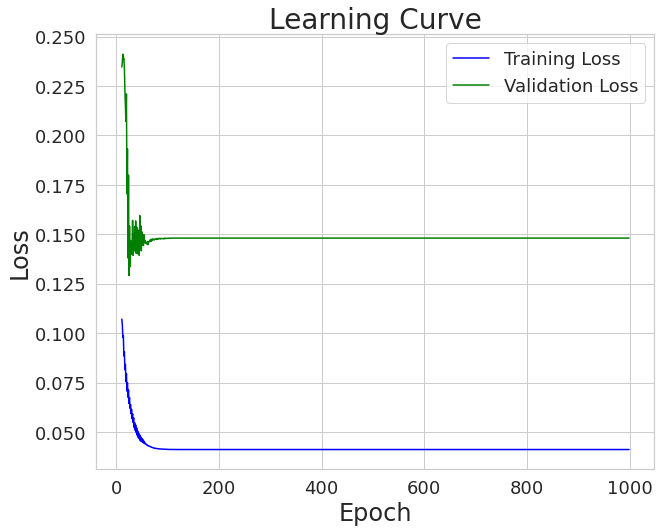

  0%|          | 0/1 [00:00<?, ?it/s]

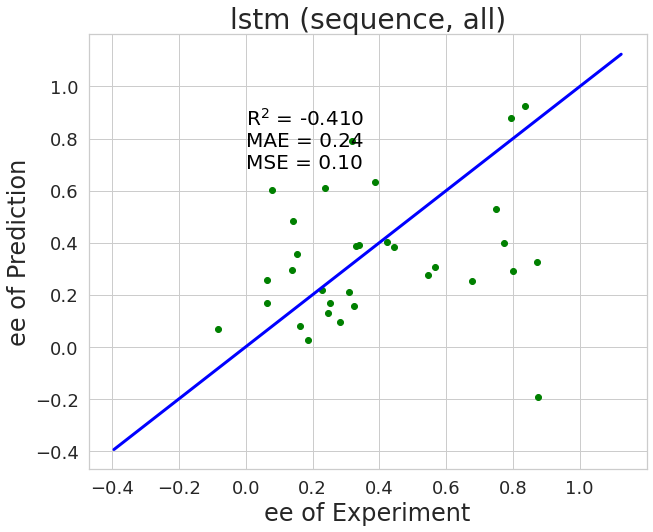

  0%|          | 0/250 [00:00<?, ?it/s]

[['SDD', 2.1474], ['DSD', 1.9262], ['ASD', 1.915], ['SAD', 1.5761], ['EES', 1.2876], ['SEE', 1.2744], ['ASE', 1.2697], ['AYS', 1.2677], ['SDA', 1.2348], ['SQT', 1.1594], ['DYG', 1.1043], ['CYG', 1.1016], ['NYG', 1.1014], ['QYG', 1.0985], ['SYG', 1.0972], ['EYG', 1.0966], ['PYG', 1.0959], ['WYG', 1.0907], ['TSQ', 1.0591], ['PEC', 1.0537], ['MKC', 1.0515], ['EQC', 1.0438], ['DKC', 1.0425], ['CKC', 1.0417], ['PQC', 1.0411], ['NKC', 1.0396], ['QKC', 1.0391], ['EPC', 1.0384], ['EKC', 1.038], ['SKC', 1.0369], ['DFG', 1.0368], ['PKC', 1.0354], ['NFG', 1.0343], ['TKC', 1.0338], ['WKC', 1.032], ['EFG', 1.0298], ['WWF', 1.0298], ['PFG', 1.0291], ['EWF', 1.0287], ['NWF', 1.0284], ['PWF', 1.0274], ['DWF', 1.0267], ['WFG', 1.0245], ['MHW', 1.0181], ['WHW', 1.0163], ['THW', 1.0157], ['SHW', 1.0146], ['QHW', 1.0137], ['CHW', 1.0133], ['NHW', 1.0132]]


In [398]:
model_label = "lstm" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='all' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=150)

Eopch    1: Total train_MSE: 0.282160 Total train_RMSE: 0.531187
Eopch    1: Total val_MSE: 0.448869 Total val_RMSE: 0.669977
Eopch    2: Total train_MSE: 0.270026 Total train_RMSE: 0.519640
Eopch    2: Total val_MSE: 0.450057 Total val_RMSE: 0.670863
Eopch    3: Total train_MSE: 0.258779 Total train_RMSE: 0.508704
Eopch    3: Total val_MSE: 0.448125 Total val_RMSE: 0.669421
Eopch    4: Total train_MSE: 0.248097 Total train_RMSE: 0.498094
Eopch    4: Total val_MSE: 0.443196 Total val_RMSE: 0.665730
Eopch    5: Total train_MSE: 0.238033 Total train_RMSE: 0.487886
Eopch    5: Total val_MSE: 0.435166 Total val_RMSE: 0.659671
Eopch    6: Total train_MSE: 0.228688 Total train_RMSE: 0.478214
Eopch    6: Total val_MSE: 0.424455 Total val_RMSE: 0.651502
Eopch    7: Total train_MSE: 0.219924 Total train_RMSE: 0.468960
Eopch    7: Total val_MSE: 0.410585 Total val_RMSE: 0.640769
Eopch    8: Total train_MSE: 0.211942 Total train_RMSE: 0.460372
Eopch    8: Total val_MSE: 0.393671 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   13: Total train_MSE: 0.177281 Total train_RMSE: 0.421048
Eopch   13: Total val_MSE: 0.295507 Total val_RMSE: 0.543606
Eopch   14: Total train_MSE: 0.171304 Total train_RMSE: 0.413889
Eopch   14: Total val_MSE: 0.278098 Total val_RMSE: 0.527350
Eopch   15: Total train_MSE: 0.165624 Total train_RMSE: 0.406969
Eopch   15: Total val_MSE: 0.261810 Total val_RMSE: 0.511673
Eopch   16: Total train_MSE: 0.160218 Total train_RMSE: 0.400272
Eopch   16: Total val_MSE: 0.248340 Total val_RMSE: 0.498337
Eopch   17: Total train_MSE: 0.154905 Total train_RMSE: 0.393580
Eopch   17: Total val_MSE: 0.236334 Total val_RMSE: 0.486142
Eopch   18: Total train_MSE: 0.149832 Total train_RMSE: 0.387081
Eopch   18: Total val_MSE: 0.225896 Total val_RMSE: 0.475286
Eopch   19: Total train_MSE: 0.144960 Total train_RMSE: 0.380736
Eopch   19: Total val_MSE: 0.217798 Total val_RMSE: 0.466689
Eopch   20: Total train_MSE: 0.140393 Total train_RMSE: 0.374690
Eopch   20: Total val_MSE: 0.210582 Total val_RMSE: 0

Eopch   81: Total train_MSE: 0.065837 Total train_RMSE: 0.256586
Eopch   81: Total val_MSE: 0.124940 Total val_RMSE: 0.353469
Eopch   82: Total train_MSE: 0.065747 Total train_RMSE: 0.256411
Eopch   82: Total val_MSE: 0.124830 Total val_RMSE: 0.353312
Eopch   83: Total train_MSE: 0.065664 Total train_RMSE: 0.256250
Eopch   83: Total val_MSE: 0.124771 Total val_RMSE: 0.353229
Eopch   84: Total train_MSE: 0.065592 Total train_RMSE: 0.256109
Eopch   84: Total val_MSE: 0.124663 Total val_RMSE: 0.353076
Eopch   85: Total train_MSE: 0.065524 Total train_RMSE: 0.255978
Eopch   85: Total val_MSE: 0.124578 Total val_RMSE: 0.352956
Eopch   86: Total train_MSE: 0.065458 Total train_RMSE: 0.255847
Eopch   86: Total val_MSE: 0.124515 Total val_RMSE: 0.352866
Eopch   87: Total train_MSE: 0.065403 Total train_RMSE: 0.255739
Eopch   87: Total val_MSE: 0.124468 Total val_RMSE: 0.352800
Eopch   88: Total train_MSE: 0.065350 Total train_RMSE: 0.255637
Eopch   88: Total val_MSE: 0.124392 Total val_RMSE: 0

Eopch  149: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  149: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  150: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  150: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  151: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  151: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  152: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  152: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  153: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  153: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  154: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  154: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  155: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  155: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  156: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  156: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  220: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  220: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  221: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  221: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  222: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  222: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  223: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  223: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  224: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  224: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  225: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  225: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  226: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  226: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  227: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  227: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  290: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  290: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  291: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  291: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  292: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  292: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  293: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  293: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  294: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  294: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  295: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  295: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  296: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  296: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  297: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  297: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  360: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  360: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  361: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  361: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  362: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  362: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  363: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  363: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  364: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  364: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  365: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  365: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  366: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  366: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  367: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  367: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  427: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  427: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  428: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  428: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  429: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  429: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  430: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  430: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  431: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  431: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  432: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  432: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  433: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  433: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  434: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  434: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  497: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  497: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  498: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  498: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  499: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  499: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  500: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  500: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  501: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  501: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  502: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  502: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  503: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  503: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  504: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  504: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  564: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  564: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  565: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  565: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  566: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  566: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  567: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  567: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  568: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  568: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  569: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  569: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  570: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  570: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  571: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  571: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  634: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  634: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  635: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  635: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  636: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  636: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  637: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  637: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  638: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  638: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  639: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  639: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  640: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  640: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  641: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  641: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  701: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  701: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  702: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  702: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  703: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  703: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  704: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  704: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  705: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  705: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  706: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  706: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  707: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  707: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  708: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  708: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  767: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  767: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  768: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  768: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  769: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  769: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  770: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  770: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  771: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  771: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  772: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  772: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  773: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  773: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  774: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  774: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  835: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  835: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  836: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  836: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  837: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  837: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  838: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  838: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  839: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  839: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  840: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  840: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  841: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  841: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  842: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  842: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  903: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  903: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  904: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  904: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  905: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  905: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  906: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  906: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  907: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  907: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  908: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  908: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  909: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  909: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  910: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  910: Total val_MSE: 0.123832 Total val_RMSE: 0

Eopch  971: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  971: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  972: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  972: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  973: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  973: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  974: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  974: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  975: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  975: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  976: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  976: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  977: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  977: Total val_MSE: 0.123832 Total val_RMSE: 0.351898
Eopch  978: Total train_MSE: 0.064820 Total train_RMSE: 0.254598
Eopch  978: Total val_MSE: 0.123832 Total val_RMSE: 0

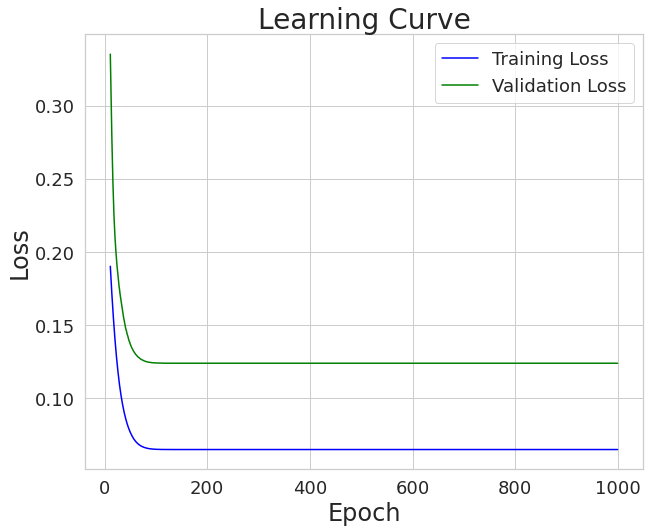

  0%|          | 0/1 [00:00<?, ?it/s]

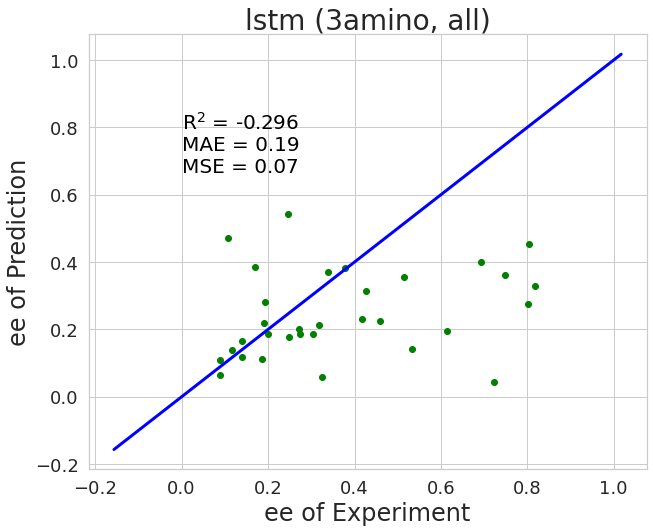

  0%|          | 0/250 [00:00<?, ?it/s]

[['PYH', 0.6895], ['PVH', 0.6738], ['CKP', 0.6284], ['RDP', 0.6247], ['PLH', 0.6213], ['CRP', 0.6117], ['NYH', 0.6116], ['WWP', 0.6093], ['PLY', 0.606], ['KDP', 0.6038], ['RNP', 0.6023], ['GYH', 0.6], ['PVY', 0.5994], ['DGG', 0.5985], ['CNP', 0.5972], ['SYH', 0.5958], ['PGG', 0.5953], ['PGH', 0.5924], ['PYF', 0.5915], ['VKP', 0.5878], ['KYH', 0.5878], ['DYH', 0.5852], ['VLY', 0.5842], ['PNH', 0.584], ['PFH', 0.5826], ['PMH', 0.5819], ['TYH', 0.5818], ['KNP', 0.5805], ['PHH', 0.5799], ['WYH', 0.5782], ['CDP', 0.5766], ['DDG', 0.5756], ['EYH', 0.5733], ['GDP', 0.573], ['LLY', 0.569], ['GNP', 0.5669], ['MYH', 0.5652], ['VYH', 0.5634], ['CGP', 0.5619], ['CAP', 0.5611], ['YYH', 0.561], ['VAP', 0.5606], ['ALP', 0.5603], ['PTH', 0.5591], ['RKP', 0.5589], ['PDG', 0.5586], ['RRP', 0.5577], ['KKP', 0.557], ['MLP', 0.5536], ['AYH', 0.553]]


In [407]:
model_label = "lstm" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='all' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=150)

In [359]:
predict_dfs.keys()

dict_keys(['cnn (sequence, all)', 'cnn (3amino, all)', 'lstm (sequence, all)', 'lstm (3amino, all)'])

### desc_flag='pssm'

Eopch    1: Total train_MSE: 0.073591 Total train_RMSE: 0.271276
Eopch    1: Total val_MSE: 0.117086 Total val_RMSE: 0.342179
Eopch    2: Total train_MSE: 0.069840 Total train_RMSE: 0.264272
Eopch    2: Total val_MSE: 0.135072 Total val_RMSE: 0.367522
Eopch    3: Total train_MSE: 0.065729 Total train_RMSE: 0.256376
Eopch    3: Total val_MSE: 0.112667 Total val_RMSE: 0.335659
Eopch    4: Total train_MSE: 0.067512 Total train_RMSE: 0.259831
Eopch    4: Total val_MSE: 0.114823 Total val_RMSE: 0.338856
Eopch    5: Total train_MSE: 0.065863 Total train_RMSE: 0.256639
Eopch    5: Total val_MSE: 0.112126 Total val_RMSE: 0.334852
Eopch    6: Total train_MSE: 0.065663 Total train_RMSE: 0.256248
Eopch    6: Total val_MSE: 0.110870 Total val_RMSE: 0.332971
Eopch    7: Total train_MSE: 0.065475 Total train_RMSE: 0.255880
Eopch    7: Total val_MSE: 0.109293 Total val_RMSE: 0.330595
Eopch    8: Total train_MSE: 0.065519 Total train_RMSE: 0.255967
Eopch    8: Total val_MSE: 0.109324 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   20: Total train_MSE: 0.064559 Total train_RMSE: 0.254084
Eopch   20: Total val_MSE: 0.108102 Total val_RMSE: 0.328789
Eopch   21: Total train_MSE: 0.064345 Total train_RMSE: 0.253663
Eopch   21: Total val_MSE: 0.107357 Total val_RMSE: 0.327654
Eopch   22: Total train_MSE: 0.064363 Total train_RMSE: 0.253700
Eopch   22: Total val_MSE: 0.107935 Total val_RMSE: 0.328534
Eopch   23: Total train_MSE: 0.064125 Total train_RMSE: 0.253230
Eopch   23: Total val_MSE: 0.107232 Total val_RMSE: 0.327462
Eopch   24: Total train_MSE: 0.064178 Total train_RMSE: 0.253334
Eopch   24: Total val_MSE: 0.108031 Total val_RMSE: 0.328681
Eopch   25: Total train_MSE: 0.064029 Total train_RMSE: 0.253039
Eopch   25: Total val_MSE: 0.107115 Total val_RMSE: 0.327285
Eopch   26: Total train_MSE: 0.064117 Total train_RMSE: 0.253213
Eopch   26: Total val_MSE: 0.108010 Total val_RMSE: 0.328649
Eopch   27: Total train_MSE: 0.063931 Total train_RMSE: 0.252846
Eopch   27: Total val_MSE: 0.107407 Total val_RMSE: 0

Eopch   97: Total train_MSE: 0.061983 Total train_RMSE: 0.248964
Eopch   97: Total val_MSE: 0.106187 Total val_RMSE: 0.325863
Eopch   98: Total train_MSE: 0.061981 Total train_RMSE: 0.248960
Eopch   98: Total val_MSE: 0.106180 Total val_RMSE: 0.325853
Eopch   99: Total train_MSE: 0.061980 Total train_RMSE: 0.248957
Eopch   99: Total val_MSE: 0.106184 Total val_RMSE: 0.325859
Eopch  100: Total train_MSE: 0.061978 Total train_RMSE: 0.248954
Eopch  100: Total val_MSE: 0.106183 Total val_RMSE: 0.325857
Eopch  101: Total train_MSE: 0.061976 Total train_RMSE: 0.248951
Eopch  101: Total val_MSE: 0.106186 Total val_RMSE: 0.325861
Eopch  102: Total train_MSE: 0.061975 Total train_RMSE: 0.248947
Eopch  102: Total val_MSE: 0.106181 Total val_RMSE: 0.325854
Eopch  103: Total train_MSE: 0.061973 Total train_RMSE: 0.248945
Eopch  103: Total val_MSE: 0.106177 Total val_RMSE: 0.325848
Eopch  104: Total train_MSE: 0.061972 Total train_RMSE: 0.248943
Eopch  104: Total val_MSE: 0.106179 Total val_RMSE: 0

Eopch  166: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  166: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  167: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  167: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  168: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  168: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  169: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  169: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  170: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  170: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  171: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  171: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  172: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  172: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  173: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  173: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  240: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  240: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  241: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  241: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  242: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  242: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  243: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  243: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  244: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  244: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  245: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  245: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  246: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  246: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  247: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  247: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  312: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  312: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  313: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  313: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  314: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  314: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  315: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  315: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  316: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  316: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  317: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  317: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  318: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  318: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  319: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  319: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  384: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  384: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  385: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  385: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  386: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  386: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  387: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  387: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  388: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  388: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  389: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  389: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  390: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  390: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  391: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  391: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  454: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  454: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  455: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  455: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  456: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  456: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  457: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  457: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  458: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  458: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  459: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  459: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  460: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  460: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  461: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  461: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  523: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  523: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  524: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  524: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  525: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  525: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  526: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  526: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  527: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  527: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  528: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  528: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  529: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  529: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  530: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  530: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  590: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  590: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  591: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  591: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  592: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  592: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  593: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  593: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  594: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  594: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  595: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  595: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  596: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  596: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  597: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  597: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  658: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  658: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  659: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  659: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  660: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  660: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  661: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  661: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  662: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  662: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  663: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  663: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  664: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  664: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  665: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  665: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  728: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  728: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  729: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  729: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  730: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  730: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  731: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  731: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  732: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  732: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  733: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  733: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  734: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  734: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  735: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  735: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  797: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  797: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  798: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  798: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  799: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  799: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  800: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  800: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  801: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  801: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  802: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  802: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  803: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  803: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  804: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  804: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  863: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  863: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  864: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  864: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  865: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  865: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  866: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  866: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  867: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  867: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  868: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  868: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  869: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  869: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  870: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  870: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  931: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  931: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  932: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  932: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  933: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  933: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  934: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  934: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  935: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  935: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  936: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  936: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  937: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  937: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch  938: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  938: Total val_MSE: 0.106172 Total val_RMSE: 0

Eopch  999: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch  999: Total val_MSE: 0.106172 Total val_RMSE: 0.325841
Eopch 1000: Total train_MSE: 0.061962 Total train_RMSE: 0.248921
Eopch 1000: Total val_MSE: 0.106172 Total val_RMSE: 0.325841


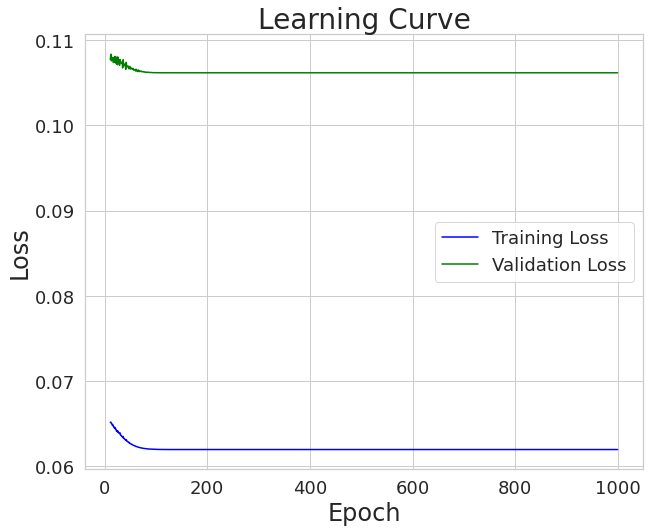

  0%|          | 0/1 [00:00<?, ?it/s]

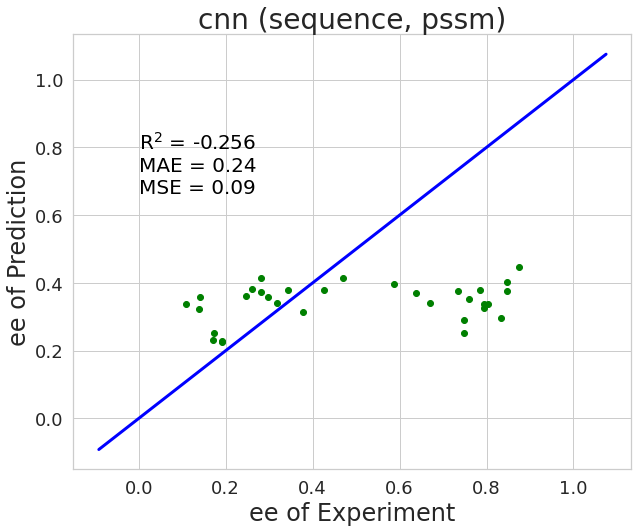

  0%|          | 0/250 [00:00<?, ?it/s]

[['LHR', 0.4932], ['LIR', 0.4917], ['VHK', 0.4882], ['MHR', 0.486], ['VHR', 0.4858], ['FHR', 0.4858], ['LLR', 0.4822], ['LRR', 0.4821], ['LMR', 0.4806], ['VIR', 0.4806], ['VER', 0.4803], ['LFR', 0.48], ['VAR', 0.4799], ['LPR', 0.4792], ['MIR', 0.4762], ['CHR', 0.4759], ['MGR', 0.4757], ['IHR', 0.4757], ['LER', 0.4756], ['FGR', 0.4756], ['LYR', 0.4744], ['MKR', 0.4739], ['VQR', 0.4738], ['LHQ', 0.4734], ['VPR', 0.4726], ['VGK', 0.4725], ['LGR', 0.4724], ['MRR', 0.472], ['VHQ', 0.4719], ['LVR', 0.4715], ['LKR', 0.4714], ['VLR', 0.4711], ['VRR', 0.471], ['FRR', 0.47], ['VMR', 0.4699], ['VRK', 0.4691], ['VFR', 0.469], ['FIR', 0.4688], ['LEK', 0.4684], ['VHH', 0.4682], ['IAR', 0.4681], ['IRR', 0.4665], ['LHK', 0.4663], ['LQR', 0.4656], ['MYR', 0.465], ['LIK', 0.4647], ['MHK', 0.4647], ['VHT', 0.4646], ['LHS', 0.4641], ['IIR', 0.4639]]


In [416]:
model_label = "cnn" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='pssm' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

Eopch    1: Total train_MSE: 0.236920 Total train_RMSE: 0.486744
Eopch    1: Total val_MSE: 0.141512 Total val_RMSE: 0.376181
Eopch    2: Total train_MSE: 0.203775 Total train_RMSE: 0.451414
Eopch    2: Total val_MSE: 0.121825 Total val_RMSE: 0.349034
Eopch    3: Total train_MSE: 0.174650 Total train_RMSE: 0.417911
Eopch    3: Total val_MSE: 0.103077 Total val_RMSE: 0.321055
Eopch    4: Total train_MSE: 0.149956 Total train_RMSE: 0.387241
Eopch    4: Total val_MSE: 0.086305 Total val_RMSE: 0.293777
Eopch    5: Total train_MSE: 0.129601 Total train_RMSE: 0.360002
Eopch    5: Total val_MSE: 0.072514 Total val_RMSE: 0.269283
Eopch    6: Total train_MSE: 0.113806 Total train_RMSE: 0.337352
Eopch    6: Total val_MSE: 0.062268 Total val_RMSE: 0.249535
Eopch    7: Total train_MSE: 0.102888 Total train_RMSE: 0.320762
Eopch    7: Total val_MSE: 0.056027 Total val_RMSE: 0.236700
Eopch    8: Total train_MSE: 0.096999 Total train_RMSE: 0.311447
Eopch    8: Total val_MSE: 0.053599 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   18: Total val_MSE: 0.050799 Total val_RMSE: 0.225386
Eopch   19: Total train_MSE: 0.085540 Total train_RMSE: 0.292472
Eopch   19: Total val_MSE: 0.050640 Total val_RMSE: 0.225034
Eopch   20: Total train_MSE: 0.084815 Total train_RMSE: 0.291231
Eopch   20: Total val_MSE: 0.050456 Total val_RMSE: 0.224625
Eopch   21: Total train_MSE: 0.084099 Total train_RMSE: 0.289999
Eopch   21: Total val_MSE: 0.050327 Total val_RMSE: 0.224336
Eopch   22: Total train_MSE: 0.083444 Total train_RMSE: 0.288868
Eopch   22: Total val_MSE: 0.050133 Total val_RMSE: 0.223905
Eopch   23: Total train_MSE: 0.082890 Total train_RMSE: 0.287907
Eopch   23: Total val_MSE: 0.049973 Total val_RMSE: 0.223546
Eopch   24: Total train_MSE: 0.082336 Total train_RMSE: 0.286942
Eopch   24: Total val_MSE: 0.049853 Total val_RMSE: 0.223278
Eopch   25: Total train_MSE: 0.081787 Total train_RMSE: 0.285985
Eopch   25: Total val_MSE: 0.049682 Total val_RMSE: 0.222896
Eopch   26: Total train_MSE: 0.081282 Total train_RMSE: 0

Eopch   86: Total train_MSE: 0.071910 Total train_RMSE: 0.268161
Eopch   86: Total val_MSE: 0.047820 Total val_RMSE: 0.218677
Eopch   87: Total train_MSE: 0.071899 Total train_RMSE: 0.268140
Eopch   87: Total val_MSE: 0.047822 Total val_RMSE: 0.218682
Eopch   88: Total train_MSE: 0.071887 Total train_RMSE: 0.268118
Eopch   88: Total val_MSE: 0.047819 Total val_RMSE: 0.218676
Eopch   89: Total train_MSE: 0.071877 Total train_RMSE: 0.268099
Eopch   89: Total val_MSE: 0.047819 Total val_RMSE: 0.218675
Eopch   90: Total train_MSE: 0.071867 Total train_RMSE: 0.268080
Eopch   90: Total val_MSE: 0.047818 Total val_RMSE: 0.218672
Eopch   91: Total train_MSE: 0.071858 Total train_RMSE: 0.268063
Eopch   91: Total val_MSE: 0.047816 Total val_RMSE: 0.218669
Eopch   92: Total train_MSE: 0.071850 Total train_RMSE: 0.268048
Eopch   92: Total val_MSE: 0.047817 Total val_RMSE: 0.218672
Eopch   93: Total train_MSE: 0.071842 Total train_RMSE: 0.268034
Eopch   93: Total val_MSE: 0.047816 Total val_RMSE: 0

Eopch  153: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  153: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  154: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  154: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  155: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  155: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  156: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  156: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  157: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  157: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  158: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  158: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  159: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  159: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  160: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  160: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  239: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  239: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  240: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  240: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  241: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  241: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  242: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  242: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  243: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  243: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  244: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  244: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  245: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  245: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  246: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  246: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  311: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  311: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  312: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  312: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  313: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  313: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  314: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  314: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  315: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  315: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  316: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  316: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  317: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  317: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  318: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  318: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  382: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  382: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  383: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  383: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  384: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  384: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  385: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  385: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  386: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  386: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  387: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  387: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  388: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  388: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  389: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  389: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  453: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  453: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  454: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  454: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  455: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  455: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  456: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  456: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  457: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  457: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  458: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  458: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  459: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  459: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  460: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  460: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  524: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  524: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  525: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  525: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  526: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  526: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  527: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  527: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  528: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  528: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  529: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  529: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  530: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  530: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  531: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  531: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  595: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  595: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  596: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  596: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  597: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  597: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  598: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  598: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  599: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  599: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  600: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  600: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  601: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  601: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  602: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  602: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  666: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  666: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  667: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  667: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  668: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  668: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  669: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  669: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  670: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  670: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  671: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  671: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  672: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  672: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  673: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  673: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  735: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  736: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  736: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  737: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  737: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  738: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  738: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  739: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  739: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  740: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  740: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  741: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  741: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  742: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  742: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  743: Total train_MSE: 0.071771 Total train_RMSE: 0

Eopch  805: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  806: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  806: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  807: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  807: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  808: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  808: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  809: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  809: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  810: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  810: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  811: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  811: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  812: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  812: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  813: Total train_MSE: 0.071771 Total train_RMSE: 0

Eopch  876: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  876: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  877: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  877: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  878: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  878: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  879: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  879: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  880: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  880: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  881: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  881: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  882: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  882: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  883: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  883: Total val_MSE: 0.047811 Total val_RMSE: 0

Eopch  946: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  947: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  947: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  948: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  948: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  949: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  949: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  950: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  950: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  951: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  951: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  952: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  952: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  953: Total train_MSE: 0.071771 Total train_RMSE: 0.267901
Eopch  953: Total val_MSE: 0.047811 Total val_RMSE: 0.218658
Eopch  954: Total train_MSE: 0.071771 Total train_RMSE: 0

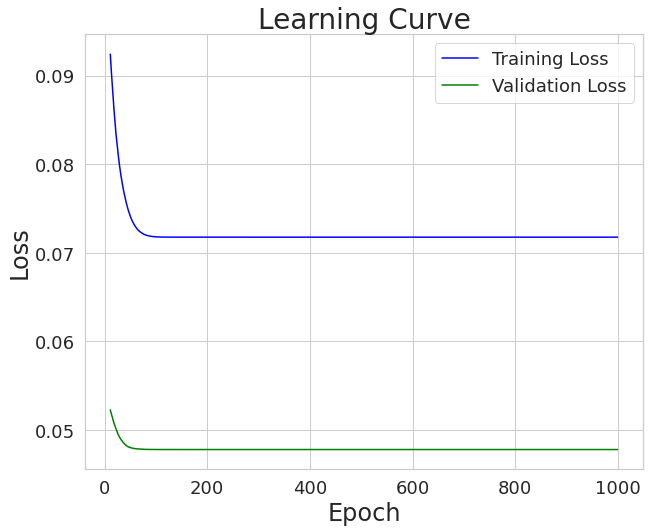

  0%|          | 0/1 [00:00<?, ?it/s]

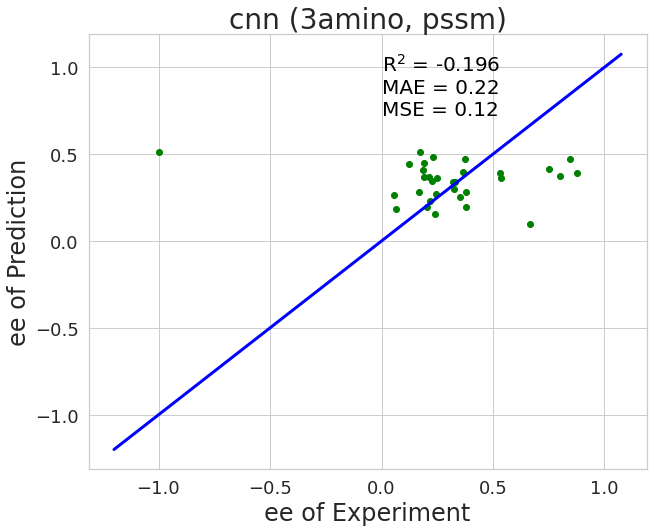

  0%|          | 0/250 [00:00<?, ?it/s]

[['RWH', 0.7375], ['RWI', 0.7128], ['AWI', 0.7066], ['RWK', 0.7054], ['TWF', 0.7051], ['PWF', 0.7044], ['RWL', 0.7011], ['TWL', 0.7001], ['TWM', 0.7], ['RWN', 0.6935], ['TWI', 0.6913], ['TWH', 0.6898], ['FWK', 0.6895], ['TWV', 0.6885], ['PWH', 0.6873], ['NWH', 0.6867], ['RWE', 0.6865], ['TWK', 0.6847], ['PWL', 0.6836], ['AWL', 0.6835], ['FWH', 0.6831], ['TWY', 0.6814], ['HWH', 0.6812], ['RWF', 0.6811], ['PWM', 0.6802], ['EWH', 0.679], ['AWM', 0.6789], ['RWD', 0.6786], ['RWG', 0.6785], ['TWG', 0.6771], ['SWH', 0.6757], ['RWR', 0.6744], ['FWG', 0.6742], ['RWQ', 0.6735], ['PWK', 0.6734], ['AWV', 0.6723], ['PWI', 0.6714], ['FWE', 0.6709], ['YWH', 0.6705], ['AWE', 0.6673], ['FWD', 0.6665], ['TWQ', 0.6663], ['SWL', 0.6653], ['TWN', 0.665], ['AWH', 0.6644], ['VWI', 0.6636], ['SWK', 0.6635], ['NWL', 0.6632], ['PWG', 0.663], ['IWE', 0.6621]]


In [418]:
model_label = "cnn" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='pssm' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=66)

Eopch    1: Total train_MSE: 0.091835 Total train_RMSE: 0.303043
Eopch    1: Total val_MSE: 0.094810 Total val_RMSE: 0.307912
Eopch    2: Total train_MSE: 0.088806 Total train_RMSE: 0.298004
Eopch    2: Total val_MSE: 0.096406 Total val_RMSE: 0.310493
Eopch    3: Total train_MSE: 0.086120 Total train_RMSE: 0.293463
Eopch    3: Total val_MSE: 0.097676 Total val_RMSE: 0.312531
Eopch    4: Total train_MSE: 0.083512 Total train_RMSE: 0.288985
Eopch    4: Total val_MSE: 0.098739 Total val_RMSE: 0.314227
Eopch    5: Total train_MSE: 0.081700 Total train_RMSE: 0.285831
Eopch    5: Total val_MSE: 0.099450 Total val_RMSE: 0.315356
Eopch    6: Total train_MSE: 0.079400 Total train_RMSE: 0.281781
Eopch    6: Total val_MSE: 0.099861 Total val_RMSE: 0.316008
Eopch    7: Total train_MSE: 0.077997 Total train_RMSE: 0.279279
Eopch    7: Total val_MSE: 0.099699 Total val_RMSE: 0.315752
Eopch    8: Total train_MSE: 0.076063 Total train_RMSE: 0.275795
Eopch    8: Total val_MSE: 0.099206 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   12: Total train_MSE: 0.071083 Total train_RMSE: 0.266614
Eopch   12: Total val_MSE: 0.093350 Total val_RMSE: 0.305533
Eopch   13: Total train_MSE: 0.070073 Total train_RMSE: 0.264712
Eopch   13: Total val_MSE: 0.091575 Total val_RMSE: 0.302614
Eopch   14: Total train_MSE: 0.068970 Total train_RMSE: 0.262621
Eopch   14: Total val_MSE: 0.089518 Total val_RMSE: 0.299196
Eopch   15: Total train_MSE: 0.068084 Total train_RMSE: 0.260930
Eopch   15: Total val_MSE: 0.087121 Total val_RMSE: 0.295163
Eopch   16: Total train_MSE: 0.067191 Total train_RMSE: 0.259212
Eopch   16: Total val_MSE: 0.083687 Total val_RMSE: 0.289287
Eopch   17: Total train_MSE: 0.066365 Total train_RMSE: 0.257615
Eopch   17: Total val_MSE: 0.081759 Total val_RMSE: 0.285935
Eopch   18: Total train_MSE: 0.065364 Total train_RMSE: 0.255664
Eopch   18: Total val_MSE: 0.078304 Total val_RMSE: 0.279829
Eopch   19: Total train_MSE: 0.064839 Total train_RMSE: 0.254636
Eopch   19: Total val_MSE: 0.075161 Total val_RMSE: 0

Eopch   84: Total val_MSE: 0.058867 Total val_RMSE: 0.242626
Eopch   85: Total train_MSE: 0.051554 Total train_RMSE: 0.227054
Eopch   85: Total val_MSE: 0.058851 Total val_RMSE: 0.242593
Eopch   86: Total train_MSE: 0.051542 Total train_RMSE: 0.227029
Eopch   86: Total val_MSE: 0.058807 Total val_RMSE: 0.242503
Eopch   87: Total train_MSE: 0.051534 Total train_RMSE: 0.227011
Eopch   87: Total val_MSE: 0.058855 Total val_RMSE: 0.242600
Eopch   88: Total train_MSE: 0.051520 Total train_RMSE: 0.226981
Eopch   88: Total val_MSE: 0.058811 Total val_RMSE: 0.242510
Eopch   89: Total train_MSE: 0.051513 Total train_RMSE: 0.226965
Eopch   89: Total val_MSE: 0.058864 Total val_RMSE: 0.242618
Eopch   90: Total train_MSE: 0.051505 Total train_RMSE: 0.226947
Eopch   90: Total val_MSE: 0.058933 Total val_RMSE: 0.242762
Eopch   91: Total train_MSE: 0.051497 Total train_RMSE: 0.226930
Eopch   91: Total val_MSE: 0.058844 Total val_RMSE: 0.242578
Eopch   92: Total train_MSE: 0.051489 Total train_RMSE: 0

Eopch  160: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  160: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  161: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  161: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  162: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  162: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  163: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  163: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  164: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  164: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  165: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  165: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  166: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  166: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  167: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  167: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  230: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  230: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  231: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  231: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  232: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  232: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  233: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  233: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  234: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  234: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  235: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  235: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  236: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  236: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  237: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  237: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  301: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  301: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  302: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  302: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  303: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  303: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  304: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  304: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  305: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  305: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  306: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  306: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  307: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  307: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  308: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  308: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  372: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  372: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  373: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  373: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  374: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  374: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  375: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  375: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  376: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  376: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  377: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  377: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  378: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  378: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  379: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  379: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  442: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  443: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  443: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  444: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  444: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  445: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  445: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  446: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  446: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  447: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  447: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  448: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  448: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  449: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  449: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  450: Total train_MSE: 0.051417 Total train_RMSE: 0

Eopch  513: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  514: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  514: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  515: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  515: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  516: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  516: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  517: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  517: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  518: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  518: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  519: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  519: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  520: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  520: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  521: Total train_MSE: 0.051417 Total train_RMSE: 0

Eopch  584: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  585: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  585: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  586: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  586: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  587: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  587: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  588: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  588: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  589: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  589: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  590: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  590: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  591: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  591: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  592: Total train_MSE: 0.051417 Total train_RMSE: 0

Eopch  655: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  656: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  656: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  657: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  657: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  658: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  658: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  659: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  659: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  660: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  660: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  661: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  661: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  662: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  662: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  663: Total train_MSE: 0.051417 Total train_RMSE: 0

Eopch  726: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  726: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  727: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  727: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  728: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  728: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  729: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  729: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  730: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  730: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  731: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  731: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  732: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  732: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  733: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  733: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  797: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  797: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  798: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  798: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  799: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  799: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  800: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  800: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  801: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  801: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  802: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  802: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  803: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  803: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  804: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  804: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  869: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  869: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  870: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  870: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  871: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  871: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  872: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  872: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  873: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  873: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  874: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  874: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  875: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  875: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  876: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  876: Total val_MSE: 0.058884 Total val_RMSE: 0

Eopch  941: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  941: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  942: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  942: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  943: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  943: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  944: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  944: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  945: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  945: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  946: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  946: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  947: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  947: Total val_MSE: 0.058884 Total val_RMSE: 0.242660
Eopch  948: Total train_MSE: 0.051417 Total train_RMSE: 0.226753
Eopch  948: Total val_MSE: 0.058884 Total val_RMSE: 0

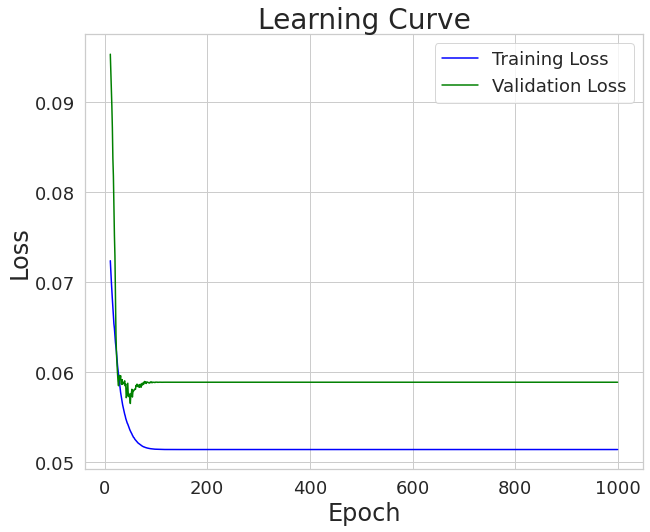

  0%|          | 0/1 [00:00<?, ?it/s]

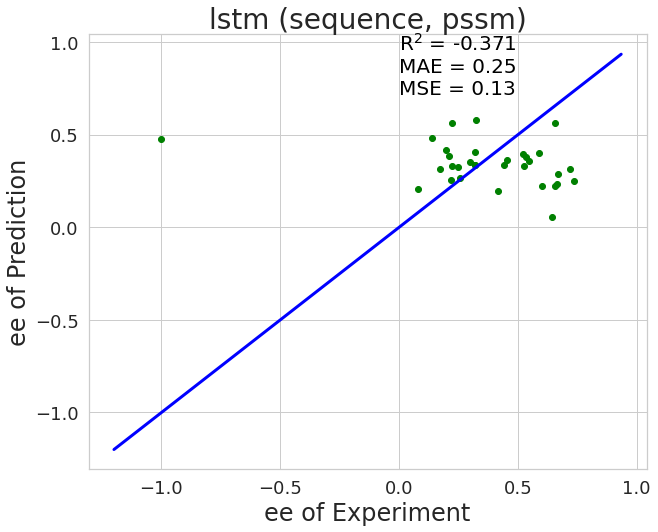

  0%|          | 0/250 [00:00<?, ?it/s]

[['APS', 1.0329], ['PPS', 1.0328], ['AES', 1.0215], ['TQS', 0.9845], ['SQA', 0.9601], ['SPA', 0.8948], ['SPP', 0.8906], ['MTS', 0.8501], ['DTS', 0.85], ['NTS', 0.8498], ['TTS', 0.8498], ['ATS', 0.8497], ['STS', 0.8497], ['GTS', 0.8497], ['QTS', 0.8497], ['PTS', 0.8497], ['KTS', 0.8496], ['ETS', 0.8496], ['TTA', 0.8398], ['ATA', 0.8397], ['PTA', 0.8396], ['QTA', 0.8394], ['TDS', 0.8382], ['PDS', 0.8382], ['QDS', 0.8381], ['TGS', 0.8335], ['NGS', 0.8334], ['AGS', 0.8334], ['PGS', 0.8334], ['SGS', 0.8333], ['QGS', 0.8332], ['DAS', 0.8298], ['NAS', 0.8297], ['TAS', 0.8297], ['SAS', 0.8296], ['PAS', 0.8295], ['QAS', 0.8295], ['STQ', 0.8292], ['QGA', 0.8276], ['TGA', 0.823], ['PGP', 0.8167], ['AGP', 0.8166], ['SGP', 0.8166], ['QGP', 0.8161], ['QDP', 0.8161], ['TAA', 0.8153], ['QAA', 0.8151], ['ESA', 0.8149], ['QWS', 0.8142], ['NMS', 0.8081]]


In [419]:
model_label = "lstm" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='pssm' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=150)

Eopch    1: Total train_MSE: 0.137136 Total train_RMSE: 0.370319
Eopch    1: Total val_MSE: 0.111125 Total val_RMSE: 0.333355
Eopch    2: Total train_MSE: 0.128531 Total train_RMSE: 0.358512
Eopch    2: Total val_MSE: 0.111740 Total val_RMSE: 0.334275
Eopch    3: Total train_MSE: 0.120344 Total train_RMSE: 0.346907
Eopch    3: Total val_MSE: 0.111964 Total val_RMSE: 0.334611
Eopch    4: Total train_MSE: 0.112819 Total train_RMSE: 0.335885
Eopch    4: Total val_MSE: 0.111862 Total val_RMSE: 0.334458
Eopch    5: Total train_MSE: 0.105998 Total train_RMSE: 0.325573
Eopch    5: Total val_MSE: 0.111515 Total val_RMSE: 0.333938
Eopch    6: Total train_MSE: 0.099939 Total train_RMSE: 0.316132
Eopch    6: Total val_MSE: 0.110693 Total val_RMSE: 0.332705
Eopch    7: Total train_MSE: 0.094827 Total train_RMSE: 0.307940
Eopch    7: Total val_MSE: 0.109563 Total val_RMSE: 0.331004
Eopch    8: Total train_MSE: 0.090265 Total train_RMSE: 0.300442
Eopch    8: Total val_MSE: 0.108288 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   13: Total val_MSE: 0.104291 Total val_RMSE: 0.322941
Eopch   14: Total train_MSE: 0.071269 Total train_RMSE: 0.266963
Eopch   14: Total val_MSE: 0.105027 Total val_RMSE: 0.324079
Eopch   15: Total train_MSE: 0.069051 Total train_RMSE: 0.262776
Eopch   15: Total val_MSE: 0.106417 Total val_RMSE: 0.326216
Eopch   16: Total train_MSE: 0.067061 Total train_RMSE: 0.258961
Eopch   16: Total val_MSE: 0.108152 Total val_RMSE: 0.328864
Eopch   17: Total train_MSE: 0.065273 Total train_RMSE: 0.255487
Eopch   17: Total val_MSE: 0.110342 Total val_RMSE: 0.332178
Eopch   18: Total train_MSE: 0.063650 Total train_RMSE: 0.252290
Eopch   18: Total val_MSE: 0.112174 Total val_RMSE: 0.334924
Eopch   19: Total train_MSE: 0.062163 Total train_RMSE: 0.249325
Eopch   19: Total val_MSE: 0.114185 Total val_RMSE: 0.337912
Eopch   20: Total train_MSE: 0.060754 Total train_RMSE: 0.246484
Eopch   20: Total val_MSE: 0.115724 Total val_RMSE: 0.340182
Eopch   21: Total train_MSE: 0.059428 Total train_RMSE: 0

Eopch   84: Total train_MSE: 0.038277 Total train_RMSE: 0.195645
Eopch   84: Total val_MSE: 0.132594 Total val_RMSE: 0.364135
Eopch   85: Total train_MSE: 0.038250 Total train_RMSE: 0.195576
Eopch   85: Total val_MSE: 0.132666 Total val_RMSE: 0.364234
Eopch   86: Total train_MSE: 0.038231 Total train_RMSE: 0.195526
Eopch   86: Total val_MSE: 0.132659 Total val_RMSE: 0.364223
Eopch   87: Total train_MSE: 0.038210 Total train_RMSE: 0.195474
Eopch   87: Total val_MSE: 0.132684 Total val_RMSE: 0.364259
Eopch   88: Total train_MSE: 0.038190 Total train_RMSE: 0.195423
Eopch   88: Total val_MSE: 0.132693 Total val_RMSE: 0.364271
Eopch   89: Total train_MSE: 0.038173 Total train_RMSE: 0.195379
Eopch   89: Total val_MSE: 0.132709 Total val_RMSE: 0.364292
Eopch   90: Total train_MSE: 0.038156 Total train_RMSE: 0.195336
Eopch   90: Total val_MSE: 0.132723 Total val_RMSE: 0.364312
Eopch   91: Total train_MSE: 0.038141 Total train_RMSE: 0.195296
Eopch   91: Total val_MSE: 0.132731 Total val_RMSE: 0

Eopch  154: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  154: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  155: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  155: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  156: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  156: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  157: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  157: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  158: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  158: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  159: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  159: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  160: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  160: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  161: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  161: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  225: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  225: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  226: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  226: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  227: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  227: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  228: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  228: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  229: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  229: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  230: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  230: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  231: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  231: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  232: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  232: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  294: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  294: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  295: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  295: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  296: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  296: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  297: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  297: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  298: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  298: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  299: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  299: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  300: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  300: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  301: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  301: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  363: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  364: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  364: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  365: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  365: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  366: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  366: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  367: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  367: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  368: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  368: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  369: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  369: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  370: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  370: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  371: Total train_MSE: 0.037992 Total train_RMSE: 0

Eopch  431: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  431: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  432: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  432: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  433: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  433: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  434: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  434: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  435: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  435: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  436: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  436: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  437: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  437: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  438: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  438: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  501: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  501: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  502: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  502: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  503: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  503: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  504: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  504: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  505: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  505: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  506: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  506: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  507: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  507: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  508: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  508: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  567: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  567: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  568: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  568: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  569: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  569: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  570: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  570: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  571: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  571: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  572: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  572: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  573: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  573: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  574: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  574: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  636: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  636: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  637: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  637: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  638: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  638: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  639: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  639: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  640: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  640: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  641: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  641: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  642: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  642: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  643: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  643: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  702: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  702: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  703: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  703: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  704: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  704: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  705: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  705: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  706: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  706: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  707: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  707: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  708: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  708: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  709: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  709: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  771: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  771: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  772: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  772: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  773: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  773: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  774: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  774: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  775: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  775: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  776: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  776: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  777: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  777: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  778: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  778: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  839: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  839: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  840: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  840: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  841: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  841: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  842: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  842: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  843: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  843: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  844: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  844: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  845: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  845: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  846: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  846: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  907: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  907: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  908: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  908: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  909: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  909: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  910: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  910: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  911: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  911: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  912: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  912: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  913: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  913: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  914: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  914: Total val_MSE: 0.132860 Total val_RMSE: 0

Eopch  975: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  975: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  976: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  976: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  977: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  977: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  978: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  978: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  979: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  979: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  980: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  980: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  981: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  981: Total val_MSE: 0.132860 Total val_RMSE: 0.364500
Eopch  982: Total train_MSE: 0.037992 Total train_RMSE: 0.194916
Eopch  982: Total val_MSE: 0.132860 Total val_RMSE: 0

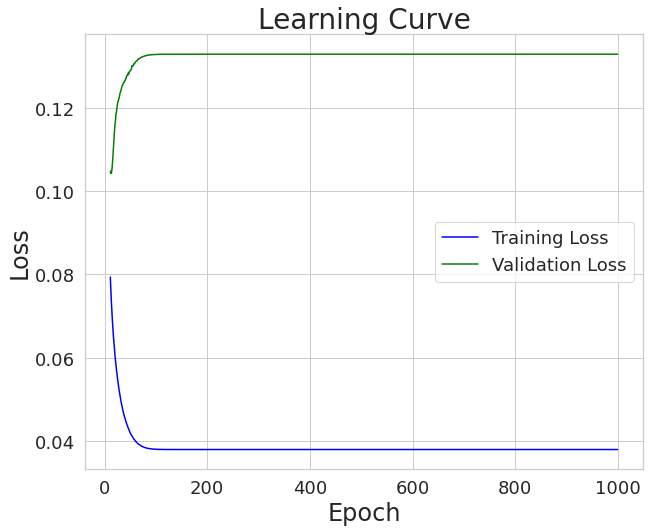

  0%|          | 0/1 [00:00<?, ?it/s]

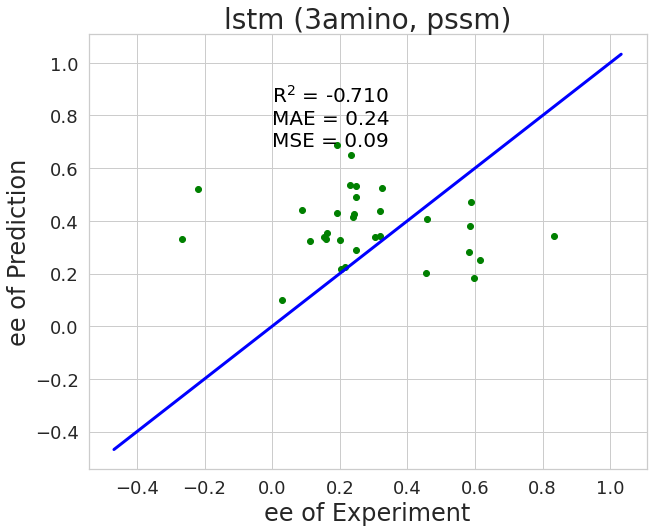

  0%|          | 0/250 [00:00<?, ?it/s]

[['CKG', 0.9787], ['PNG', 0.9474], ['AKG', 0.93], ['VKG', 0.9299], ['PKG', 0.9147], ['KNG', 0.9071], ['LKG', 0.9], ['RKG', 0.8974], ['KKG', 0.8967], ['QNG', 0.8962], ['VAP', 0.8937], ['RNG', 0.8856], ['CRG', 0.885], ['SNG', 0.8839], ['IKG', 0.883], ['ANG', 0.8808], ['MKG', 0.8764], ['GNG', 0.8752], ['TNG', 0.8739], ['SKG', 0.8715], ['GKG', 0.8714], ['CNG', 0.8709], ['PDG', 0.8703], ['QKG', 0.8701], ['PAG', 0.8677], ['VQG', 0.866], ['TKG', 0.865], ['CQG', 0.8645], ['CEG', 0.8624], ['NNG', 0.8618], ['DNG', 0.8587], ['IAP', 0.8569], ['VTP', 0.8553], ['MNG', 0.854], ['NKG', 0.8512], ['VNG', 0.8423], ['VRG', 0.8416], ['AEG', 0.8366], ['ENG', 0.8349], ['CDG', 0.8295], ['VEG', 0.8289], ['LNG', 0.8228], ['LQG', 0.8224], ['LAP', 0.8217], ['PRG', 0.8209], ['CPG', 0.8203], ['EKG', 0.82], ['VVP', 0.8199], ['DKG', 0.8181], ['ADG', 0.8169]]


In [420]:
model_label = "lstm" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='pssm' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=150)

In [422]:
predict_dfs.keys()

dict_keys(['cnn (sequence, all)', 'cnn (3amino, all)', 'lstm (sequence, all)', 'lstm (3amino, all)', 'cnn (sequence, pssm)', 'cnn (3amino, pssm)', 'lstm (sequence, pssm)', 'lstm (3amino, pssm)'])

### desc_flag='one_hot'

Eopch    1: Total train_MSE: 0.092074 Total train_RMSE: 0.303437
Eopch    1: Total val_MSE: 0.223529 Total val_RMSE: 0.472788
Eopch    2: Total train_MSE: 0.090585 Total train_RMSE: 0.300974
Eopch    2: Total val_MSE: 0.217634 Total val_RMSE: 0.466513
Eopch    3: Total train_MSE: 0.089114 Total train_RMSE: 0.298520
Eopch    3: Total val_MSE: 0.204923 Total val_RMSE: 0.452684
Eopch    4: Total train_MSE: 0.087836 Total train_RMSE: 0.296371
Eopch    4: Total val_MSE: 0.192843 Total val_RMSE: 0.439139
Eopch    5: Total train_MSE: 0.086552 Total train_RMSE: 0.294197
Eopch    5: Total val_MSE: 0.177818 Total val_RMSE: 0.421685
Eopch    6: Total train_MSE: 0.085746 Total train_RMSE: 0.292825
Eopch    6: Total val_MSE: 0.162338 Total val_RMSE: 0.402912
Eopch    7: Total train_MSE: 0.084654 Total train_RMSE: 0.290953
Eopch    7: Total val_MSE: 0.142223 Total val_RMSE: 0.377125
Eopch    8: Total train_MSE: 0.083904 Total train_RMSE: 0.289662
Eopch    8: Total val_MSE: 0.125646 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   18: Total train_MSE: 0.077941 Total train_RMSE: 0.279178
Eopch   18: Total val_MSE: 0.057700 Total val_RMSE: 0.240208
Eopch   19: Total train_MSE: 0.077124 Total train_RMSE: 0.277711
Eopch   19: Total val_MSE: 0.055709 Total val_RMSE: 0.236028
Eopch   20: Total train_MSE: 0.077040 Total train_RMSE: 0.277561
Eopch   20: Total val_MSE: 0.057571 Total val_RMSE: 0.239940
Eopch   21: Total train_MSE: 0.076176 Total train_RMSE: 0.276001
Eopch   21: Total val_MSE: 0.055490 Total val_RMSE: 0.235562
Eopch   22: Total train_MSE: 0.076376 Total train_RMSE: 0.276362
Eopch   22: Total val_MSE: 0.058181 Total val_RMSE: 0.241207
Eopch   23: Total train_MSE: 0.075722 Total train_RMSE: 0.275177
Eopch   23: Total val_MSE: 0.056743 Total val_RMSE: 0.238208
Eopch   24: Total train_MSE: 0.075342 Total train_RMSE: 0.274486
Eopch   24: Total val_MSE: 0.057448 Total val_RMSE: 0.239683
Eopch   25: Total train_MSE: 0.075000 Total train_RMSE: 0.273861
Eopch   25: Total val_MSE: 0.057411 Total val_RMSE: 0

Eopch   86: Total train_MSE: 0.068789 Total train_RMSE: 0.262276
Eopch   86: Total val_MSE: 0.066569 Total val_RMSE: 0.258009
Eopch   87: Total train_MSE: 0.068791 Total train_RMSE: 0.262280
Eopch   87: Total val_MSE: 0.066630 Total val_RMSE: 0.258128
Eopch   88: Total train_MSE: 0.068791 Total train_RMSE: 0.262280
Eopch   88: Total val_MSE: 0.066694 Total val_RMSE: 0.258252
Eopch   89: Total train_MSE: 0.068786 Total train_RMSE: 0.262270
Eopch   89: Total val_MSE: 0.066720 Total val_RMSE: 0.258303
Eopch   90: Total train_MSE: 0.068751 Total train_RMSE: 0.262204
Eopch   90: Total val_MSE: 0.066620 Total val_RMSE: 0.258108
Eopch   91: Total train_MSE: 0.068759 Total train_RMSE: 0.262220
Eopch   91: Total val_MSE: 0.066686 Total val_RMSE: 0.258237
Eopch   92: Total train_MSE: 0.068756 Total train_RMSE: 0.262214
Eopch   92: Total val_MSE: 0.066710 Total val_RMSE: 0.258283
Eopch   93: Total train_MSE: 0.068753 Total train_RMSE: 0.262208
Eopch   93: Total val_MSE: 0.066739 Total val_RMSE: 0

Eopch  157: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  158: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  158: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  159: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  159: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  160: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  160: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  161: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  161: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  162: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  162: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  163: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  163: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  164: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  164: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  165: Total train_MSE: 0.068695 Total train_RMSE: 0

Eopch  225: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  226: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  226: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  227: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  227: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  228: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  228: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  229: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  229: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  230: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  230: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  231: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  231: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  232: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  232: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  233: Total train_MSE: 0.068695 Total train_RMSE: 0

Eopch  296: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  296: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  297: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  297: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  298: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  298: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  299: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  299: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  300: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  300: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  301: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  301: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  302: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  302: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  303: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  303: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  366: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  366: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  367: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  367: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  368: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  368: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  369: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  369: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  370: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  370: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  371: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  371: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  372: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  372: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  373: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  373: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  436: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  436: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  437: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  437: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  438: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  438: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  439: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  439: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  440: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  440: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  441: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  441: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  442: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  442: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  443: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  443: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  506: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  506: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  507: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  507: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  508: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  508: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  509: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  509: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  510: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  510: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  511: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  511: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  512: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  512: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  513: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  513: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  577: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  577: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  578: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  578: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  579: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  579: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  580: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  580: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  581: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  581: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  582: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  582: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  583: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  583: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  584: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  584: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  648: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  648: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  649: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  649: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  650: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  650: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  651: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  651: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  652: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  652: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  653: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  653: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  654: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  654: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  655: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  655: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  717: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  717: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  718: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  718: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  719: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  719: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  720: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  720: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  721: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  721: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  722: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  722: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  723: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  723: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  724: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  724: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  787: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  787: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  788: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  788: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  789: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  789: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  790: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  790: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  791: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  791: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  792: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  792: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  793: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  793: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  794: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  794: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  857: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  857: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  858: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  858: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  859: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  859: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  860: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  860: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  861: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  861: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  862: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  862: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  863: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  863: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  864: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  864: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  927: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  927: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  928: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  928: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  929: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  929: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  930: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  930: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  931: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  931: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  932: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  932: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  933: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  933: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  934: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  934: Total val_MSE: 0.066869 Total val_RMSE: 0

Eopch  998: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  998: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch  999: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch  999: Total val_MSE: 0.066869 Total val_RMSE: 0.258590
Eopch 1000: Total train_MSE: 0.068695 Total train_RMSE: 0.262098
Eopch 1000: Total val_MSE: 0.066869 Total val_RMSE: 0.258590


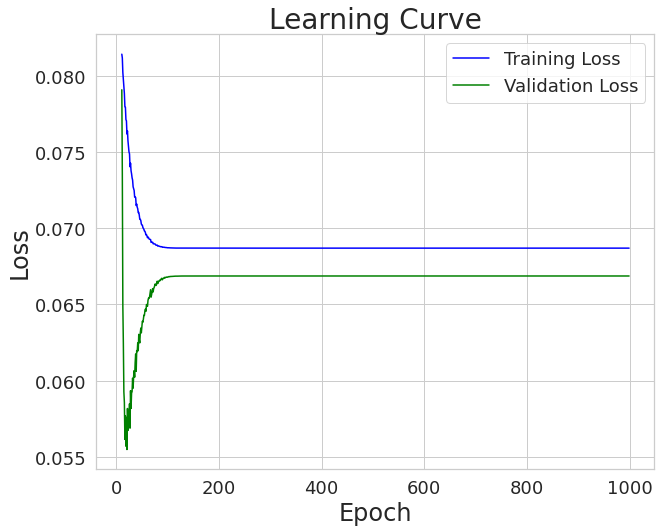

  0%|          | 0/1 [00:00<?, ?it/s]

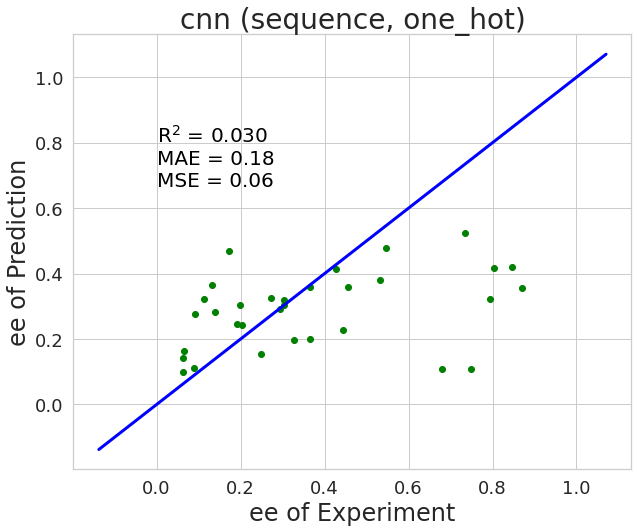

  0%|          | 0/250 [00:00<?, ?it/s]

[['TVQ', 0.6666], ['WVQ', 0.6615], ['TVN', 0.6487], ['WVN', 0.6464], ['TYQ', 0.6454], ['WYQ', 0.6397], ['TVC', 0.6353], ['TYN', 0.6329], ['TVV', 0.6308], ['WYN', 0.6306], ['TVL', 0.6286], ['WVC', 0.6275], ['WVL', 0.6262], ['WVV', 0.6262], ['TYC', 0.6261], ['TGQ', 0.6229], ['TVD', 0.6227], ['TVK', 0.6222], ['WVD', 0.6204], ['WVK', 0.6197], ['WGQ', 0.6183], ['WYC', 0.6183], ['TTQ', 0.6169], ['TGN', 0.6146], ['WGN', 0.6131], ['TEQ', 0.612], ['TYD', 0.6119], ['WTQ', 0.6116], ['TTC', 0.6105], ['TYL', 0.61], ['TEC', 0.6087], ['WYL', 0.6076], ['WYD', 0.6074], ['TTN', 0.607], ['TGC', 0.6069], ['WEQ', 0.606], ['TVF', 0.605], ['WEC', 0.6036], ['TYK', 0.6035], ['TSQ', 0.6034], ['WTC', 0.6027], ['WVF', 0.6026], ['TVE', 0.6023], ['WGC', 0.6017], ['WYK', 0.6011], ['SVQ', 0.6011], ['WTN', 0.6003], ['WVE', 0.5999], ['WSQ', 0.5988], ['TEN', 0.5988]]


In [423]:
model_label = "cnn" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='one_hot' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

Eopch    1: Total train_MSE: 0.386586 Total train_RMSE: 0.621760
Eopch    1: Total val_MSE: 0.182968 Total val_RMSE: 0.427748
Eopch    2: Total train_MSE: 0.360478 Total train_RMSE: 0.600399
Eopch    2: Total val_MSE: 0.176416 Total val_RMSE: 0.420019
Eopch    3: Total train_MSE: 0.335870 Total train_RMSE: 0.579543
Eopch    3: Total val_MSE: 0.171265 Total val_RMSE: 0.413841
Eopch    4: Total train_MSE: 0.312597 Total train_RMSE: 0.559104
Eopch    4: Total val_MSE: 0.166440 Total val_RMSE: 0.407970
Eopch    5: Total train_MSE: 0.290593 Total train_RMSE: 0.539066
Eopch    5: Total val_MSE: 0.161734 Total val_RMSE: 0.402162
Eopch    6: Total train_MSE: 0.269918 Total train_RMSE: 0.519536
Eopch    6: Total val_MSE: 0.156535 Total val_RMSE: 0.395645
Eopch    7: Total train_MSE: 0.250740 Total train_RMSE: 0.500739
Eopch    7: Total val_MSE: 0.150535 Total val_RMSE: 0.387989
Eopch    8: Total train_MSE: 0.232942 Total train_RMSE: 0.482640
Eopch    8: Total val_MSE: 0.143656 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   19: Total train_MSE: 0.120094 Total train_RMSE: 0.346546
Eopch   19: Total val_MSE: 0.109117 Total val_RMSE: 0.330328
Eopch   20: Total train_MSE: 0.115315 Total train_RMSE: 0.339581
Eopch   20: Total val_MSE: 0.111050 Total val_RMSE: 0.333241
Eopch   21: Total train_MSE: 0.111117 Total train_RMSE: 0.333342
Eopch   21: Total val_MSE: 0.112862 Total val_RMSE: 0.335949
Eopch   22: Total train_MSE: 0.107387 Total train_RMSE: 0.327699
Eopch   22: Total val_MSE: 0.114689 Total val_RMSE: 0.338657
Eopch   23: Total train_MSE: 0.104058 Total train_RMSE: 0.322581
Eopch   23: Total val_MSE: 0.116461 Total val_RMSE: 0.341265
Eopch   24: Total train_MSE: 0.101053 Total train_RMSE: 0.317888
Eopch   24: Total val_MSE: 0.118139 Total val_RMSE: 0.343713
Eopch   25: Total train_MSE: 0.098331 Total train_RMSE: 0.313578
Eopch   25: Total val_MSE: 0.119766 Total val_RMSE: 0.346072
Eopch   26: Total train_MSE: 0.095876 Total train_RMSE: 0.309638
Eopch   26: Total val_MSE: 0.121158 Total val_RMSE: 0

Eopch   85: Total val_MSE: 0.130340 Total val_RMSE: 0.361026
Eopch   86: Total train_MSE: 0.072034 Total train_RMSE: 0.268392
Eopch   86: Total val_MSE: 0.130335 Total val_RMSE: 0.361020
Eopch   87: Total train_MSE: 0.072018 Total train_RMSE: 0.268361
Eopch   87: Total val_MSE: 0.130328 Total val_RMSE: 0.361010
Eopch   88: Total train_MSE: 0.072002 Total train_RMSE: 0.268333
Eopch   88: Total val_MSE: 0.130331 Total val_RMSE: 0.361014
Eopch   89: Total train_MSE: 0.071988 Total train_RMSE: 0.268306
Eopch   89: Total val_MSE: 0.130326 Total val_RMSE: 0.361007
Eopch   90: Total train_MSE: 0.071975 Total train_RMSE: 0.268282
Eopch   90: Total val_MSE: 0.130325 Total val_RMSE: 0.361005
Eopch   91: Total train_MSE: 0.071964 Total train_RMSE: 0.268260
Eopch   91: Total val_MSE: 0.130325 Total val_RMSE: 0.361005
Eopch   92: Total train_MSE: 0.071953 Total train_RMSE: 0.268240
Eopch   92: Total val_MSE: 0.130328 Total val_RMSE: 0.361010
Eopch   93: Total train_MSE: 0.071943 Total train_RMSE: 0

Eopch  153: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  153: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  154: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  154: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  155: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  155: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  156: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  156: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  157: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  157: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  158: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  158: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  159: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  159: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  160: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  160: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  219: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  219: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  220: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  220: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  221: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  221: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  222: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  222: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  223: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  223: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  224: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  224: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  225: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  225: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  226: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  226: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  285: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  285: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  286: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  286: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  287: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  287: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  288: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  288: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  289: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  289: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  290: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  290: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  291: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  291: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  292: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  292: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  357: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  357: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  358: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  358: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  359: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  359: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  360: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  360: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  361: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  361: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  362: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  362: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  363: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  363: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  364: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  364: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  429: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  429: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  430: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  430: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  431: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  431: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  432: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  432: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  433: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  433: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  434: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  434: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  435: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  435: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  436: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  436: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  495: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  495: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  496: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  496: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  497: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  497: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  498: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  498: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  499: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  499: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  500: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  500: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  501: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  501: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  502: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  502: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  561: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  561: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  562: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  562: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  563: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  563: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  564: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  564: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  565: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  565: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  566: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  566: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  567: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  567: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  568: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  568: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  628: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  628: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  629: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  629: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  630: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  630: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  631: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  631: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  632: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  632: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  633: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  633: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  634: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  634: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  635: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  635: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  698: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  698: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  699: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  699: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  700: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  700: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  701: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  701: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  702: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  702: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  703: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  703: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  704: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  704: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  705: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  705: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  767: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  768: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  768: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  769: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  769: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  770: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  770: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  771: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  771: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  772: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  772: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  773: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  773: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  774: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  774: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  775: Total train_MSE: 0.071848 Total train_RMSE: 0

Eopch  835: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  836: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  836: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  837: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  837: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  838: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  838: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  839: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  839: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  840: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  840: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  841: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  841: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  842: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  842: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  843: Total train_MSE: 0.071848 Total train_RMSE: 0

Eopch  901: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  901: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  902: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  902: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  903: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  903: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  904: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  904: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  905: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  905: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  906: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  906: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  907: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  907: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  908: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  908: Total val_MSE: 0.130318 Total val_RMSE: 0

Eopch  969: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  969: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  970: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  970: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  971: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  971: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  972: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  972: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  973: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  973: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  974: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  974: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  975: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  975: Total val_MSE: 0.130318 Total val_RMSE: 0.360996
Eopch  976: Total train_MSE: 0.071848 Total train_RMSE: 0.268045
Eopch  976: Total val_MSE: 0.130318 Total val_RMSE: 0

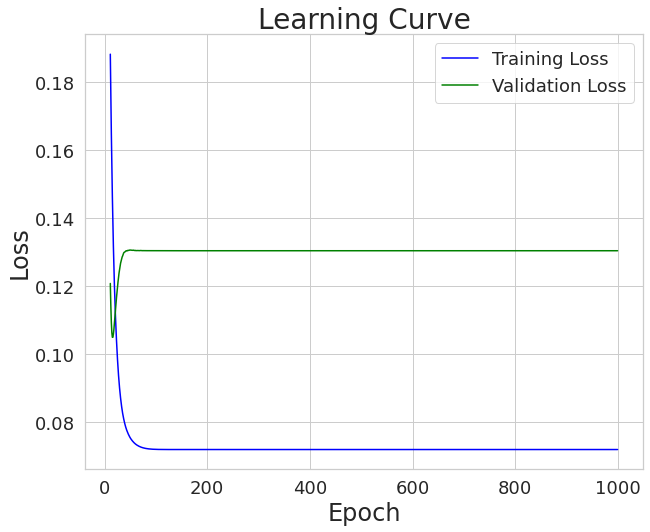

  0%|          | 0/1 [00:00<?, ?it/s]

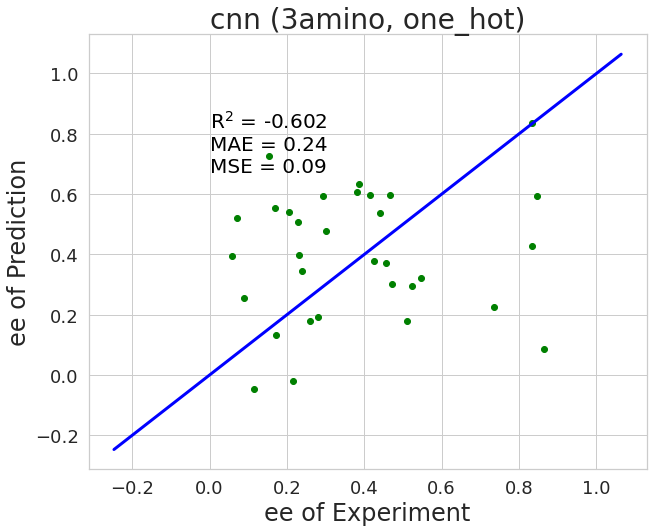

  0%|          | 0/250 [00:00<?, ?it/s]

[['KWW', 1.1824], ['KWC', 1.1619], ['KWD', 1.0917], ['KWY', 1.0692], ['WWT', 1.0556], ['KWT', 1.0504], ['WMT', 1.0333], ['WKT', 1.0067], ['WWW', 0.9995], ['KWQ', 0.9912], ['KWN', 0.9895], ['WMC', 0.9866], ['WWC', 0.9841], ['WKW', 0.9734], ['KWI', 0.9706], ['WTT', 0.9675], ['RWD', 0.9605], ['WFT', 0.9562], ['WKC', 0.9554], ['WTC', 0.9553], ['RWW', 0.9498], ['WMQ', 0.9462], ['LWW', 0.9447], ['MWW', 0.9441], ['WMD', 0.9418], ['MWC', 0.9403], ['KWS', 0.9377], ['LWC', 0.9363], ['WMW', 0.9328], ['RMD', 0.9327], ['WCT', 0.9279], ['WRT', 0.9277], ['WST', 0.9245], ['IWW', 0.9243], ['FWW', 0.9232], ['RMC', 0.9189], ['IWC', 0.9182], ['KWE', 0.9179], ['RWC', 0.9131], ['RWT', 0.9127], ['WYT', 0.91], ['WDT', 0.9082], ['IMD', 0.9045], ['WTD', 0.9035], ['KYC', 0.8967], ['WWQ', 0.8964], ['IWD', 0.8945], ['RVC', 0.8945], ['WMN', 0.8938], ['WKD', 0.8922]]


In [424]:
model_label = "cnn" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='one_hot' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=66)

Eopch    1: Total train_MSE: 0.110105 Total train_RMSE: 0.331821
Eopch    1: Total val_MSE: 0.098627 Total val_RMSE: 0.314050
Eopch    2: Total train_MSE: 0.107922 Total train_RMSE: 0.328515
Eopch    2: Total val_MSE: 0.097374 Total val_RMSE: 0.312048
Eopch    3: Total train_MSE: 0.105843 Total train_RMSE: 0.325336
Eopch    3: Total val_MSE: 0.096329 Total val_RMSE: 0.310370
Eopch    4: Total train_MSE: 0.103876 Total train_RMSE: 0.322297
Eopch    4: Total val_MSE: 0.095459 Total val_RMSE: 0.308964
Eopch    5: Total train_MSE: 0.101991 Total train_RMSE: 0.319360
Eopch    5: Total val_MSE: 0.094719 Total val_RMSE: 0.307765
Eopch    6: Total train_MSE: 0.100075 Total train_RMSE: 0.316346
Eopch    6: Total val_MSE: 0.094091 Total val_RMSE: 0.306743
Eopch    7: Total train_MSE: 0.098168 Total train_RMSE: 0.313317
Eopch    7: Total val_MSE: 0.093536 Total val_RMSE: 0.305836
Eopch    8: Total train_MSE: 0.096326 Total train_RMSE: 0.310365
Eopch    8: Total val_MSE: 0.092887 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   12: Total train_MSE: 0.089601 Total train_RMSE: 0.299334
Eopch   12: Total val_MSE: 0.089996 Total val_RMSE: 0.299994
Eopch   13: Total train_MSE: 0.088118 Total train_RMSE: 0.296846
Eopch   13: Total val_MSE: 0.089505 Total val_RMSE: 0.299174
Eopch   14: Total train_MSE: 0.086742 Total train_RMSE: 0.294519
Eopch   14: Total val_MSE: 0.088843 Total val_RMSE: 0.298065
Eopch   15: Total train_MSE: 0.085403 Total train_RMSE: 0.292238
Eopch   15: Total val_MSE: 0.088148 Total val_RMSE: 0.296897
Eopch   16: Total train_MSE: 0.084192 Total train_RMSE: 0.290158
Eopch   16: Total val_MSE: 0.087424 Total val_RMSE: 0.295676
Eopch   17: Total train_MSE: 0.083030 Total train_RMSE: 0.288149
Eopch   17: Total val_MSE: 0.086316 Total val_RMSE: 0.293796
Eopch   18: Total train_MSE: 0.081983 Total train_RMSE: 0.286326
Eopch   18: Total val_MSE: 0.085491 Total val_RMSE: 0.292389
Eopch   19: Total train_MSE: 0.081001 Total train_RMSE: 0.284608
Eopch   19: Total val_MSE: 0.085152 Total val_RMSE: 0

Eopch   84: Total train_MSE: 0.069036 Total train_RMSE: 0.262747
Eopch   84: Total val_MSE: 0.074880 Total val_RMSE: 0.273643
Eopch   85: Total train_MSE: 0.069025 Total train_RMSE: 0.262727
Eopch   85: Total val_MSE: 0.074831 Total val_RMSE: 0.273553
Eopch   86: Total train_MSE: 0.069015 Total train_RMSE: 0.262708
Eopch   86: Total val_MSE: 0.074844 Total val_RMSE: 0.273576
Eopch   87: Total train_MSE: 0.069006 Total train_RMSE: 0.262690
Eopch   87: Total val_MSE: 0.074861 Total val_RMSE: 0.273607
Eopch   88: Total train_MSE: 0.068998 Total train_RMSE: 0.262675
Eopch   88: Total val_MSE: 0.074878 Total val_RMSE: 0.273638
Eopch   89: Total train_MSE: 0.068991 Total train_RMSE: 0.262661
Eopch   89: Total val_MSE: 0.074871 Total val_RMSE: 0.273626
Eopch   90: Total train_MSE: 0.068983 Total train_RMSE: 0.262647
Eopch   90: Total val_MSE: 0.074870 Total val_RMSE: 0.273623
Eopch   91: Total train_MSE: 0.068977 Total train_RMSE: 0.262635
Eopch   91: Total val_MSE: 0.074862 Total val_RMSE: 0

Eopch  151: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  151: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  152: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  152: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  153: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  153: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  154: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  154: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  155: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  155: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  156: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  156: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  157: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  157: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  158: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  158: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  286: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  286: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  287: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  287: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  288: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  288: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  289: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  289: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  290: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  290: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  291: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  291: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  292: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  292: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  293: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  293: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  356: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  356: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  357: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  357: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  358: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  358: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  359: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  359: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  360: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  360: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  361: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  361: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  362: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  362: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  363: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  363: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  427: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  427: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  428: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  428: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  429: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  429: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  430: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  430: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  431: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  431: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  432: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  432: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  433: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  433: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  434: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  434: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  497: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  497: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  498: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  498: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  499: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  499: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  500: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  500: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  501: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  501: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  502: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  502: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  503: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  503: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  504: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  504: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  568: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  568: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  569: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  569: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  570: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  570: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  571: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  571: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  572: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  572: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  573: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  573: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  574: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  574: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  575: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  575: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  639: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  639: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  640: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  640: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  641: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  641: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  642: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  642: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  643: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  643: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  644: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  644: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  645: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  645: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  646: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  646: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  710: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  710: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  711: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  711: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  712: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  712: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  713: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  713: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  714: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  714: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  715: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  715: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  716: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  716: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  717: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  717: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  781: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  781: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  782: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  782: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  783: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  783: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  784: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  784: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  785: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  785: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  786: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  786: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  787: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  787: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  788: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  788: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  852: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  852: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  853: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  853: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  854: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  854: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  855: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  855: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  856: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  856: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  857: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  857: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  858: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  858: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  859: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  859: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  923: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  923: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  924: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  924: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  925: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  925: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  926: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  926: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  927: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  927: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  928: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  928: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  929: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  929: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  930: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  930: Total val_MSE: 0.074915 Total val_RMSE: 0

Eopch  994: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  994: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  995: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  995: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  996: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  996: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  997: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  997: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  998: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  998: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch  999: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch  999: Total val_MSE: 0.074915 Total val_RMSE: 0.273705
Eopch 1000: Total train_MSE: 0.068913 Total train_RMSE: 0.262514
Eopch 1000: Total val_MSE: 0.074915 Total val_RMSE: 0.273705


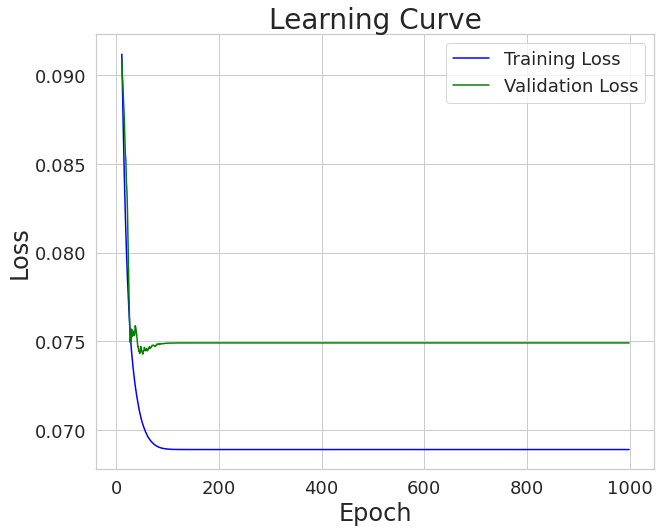

  0%|          | 0/1 [00:00<?, ?it/s]

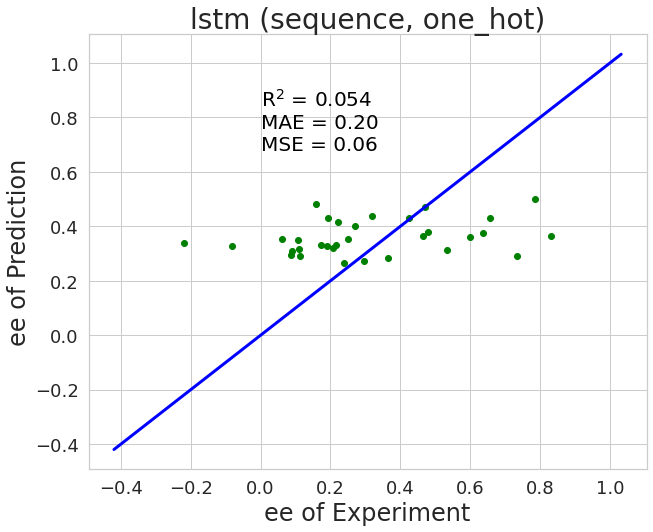

  0%|          | 0/250 [00:00<?, ?it/s]

[['DCC', 0.565], ['CCC', 0.5649], ['KCC', 0.5649], ['PCC', 0.5648], ['YCC', 0.5647], ['WCC', 0.5647], ['ICC', 0.5647], ['GCC', 0.5646], ['ECC', 0.5646], ['QCC', 0.5645], ['TCC', 0.5645], ['FCC', 0.5644], ['VCC', 0.5644], ['RCC', 0.5644], ['SCC', 0.5642], ['ACC', 0.5642], ['HCC', 0.5641], ['LCC', 0.564], ['MCC', 0.564], ['NCC', 0.5637], ['DDC', 0.5495], ['CDC', 0.5494], ['KDC', 0.5494], ['PDC', 0.5493], ['YDC', 0.5493], ['IDC', 0.5492], ['WDC', 0.5492], ['GDC', 0.5492], ['EDC', 0.5492], ['QDC', 0.5491], ['FDC', 0.5491], ['TDC', 0.549], ['RDC', 0.5489], ['VDC', 0.5489], ['SDC', 0.5488], ['ADC', 0.5488], ['HDC', 0.5487], ['LDC', 0.5486], ['MDC', 0.5485], ['NDC', 0.5484], ['DPC', 0.5174], ['CPC', 0.5173], ['KPC', 0.5173], ['PPC', 0.5172], ['WPC', 0.5171], ['YPC', 0.517], ['IPC', 0.517], ['GPC', 0.517], ['EPC', 0.517], ['QPC', 0.5169]]


In [425]:
model_label = "lstm" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='one_hot' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

Eopch    1: Total train_MSE: 0.466643 Total train_RMSE: 0.683112
Eopch    1: Total val_MSE: 0.434606 Total val_RMSE: 0.659247
Eopch    2: Total train_MSE: 0.449225 Total train_RMSE: 0.670242
Eopch    2: Total val_MSE: 0.434564 Total val_RMSE: 0.659215
Eopch    3: Total train_MSE: 0.432315 Total train_RMSE: 0.657506
Eopch    3: Total val_MSE: 0.434183 Total val_RMSE: 0.658925
Eopch    4: Total train_MSE: 0.415870 Total train_RMSE: 0.644880
Eopch    4: Total val_MSE: 0.433792 Total val_RMSE: 0.658629
Eopch    5: Total train_MSE: 0.399880 Total train_RMSE: 0.632361
Eopch    5: Total val_MSE: 0.432281 Total val_RMSE: 0.657481
Eopch    6: Total train_MSE: 0.384500 Total train_RMSE: 0.620080
Eopch    6: Total val_MSE: 0.430173 Total val_RMSE: 0.655876
Eopch    7: Total train_MSE: 0.369697 Total train_RMSE: 0.608027
Eopch    7: Total val_MSE: 0.427365 Total val_RMSE: 0.653732
Eopch    8: Total train_MSE: 0.355431 Total train_RMSE: 0.596180
Eopch    8: Total val_MSE: 0.424249 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   13: Total train_MSE: 0.292882 Total train_RMSE: 0.541185
Eopch   13: Total val_MSE: 0.393805 Total val_RMSE: 0.627539
Eopch   14: Total train_MSE: 0.281959 Total train_RMSE: 0.530998
Eopch   14: Total val_MSE: 0.382627 Total val_RMSE: 0.618569
Eopch   15: Total train_MSE: 0.271534 Total train_RMSE: 0.521089
Eopch   15: Total val_MSE: 0.371208 Total val_RMSE: 0.609269
Eopch   16: Total train_MSE: 0.261671 Total train_RMSE: 0.511537
Eopch   16: Total val_MSE: 0.356821 Total val_RMSE: 0.597345
Eopch   17: Total train_MSE: 0.252316 Total train_RMSE: 0.502311
Eopch   17: Total val_MSE: 0.341460 Total val_RMSE: 0.584346
Eopch   18: Total train_MSE: 0.243526 Total train_RMSE: 0.493484
Eopch   18: Total val_MSE: 0.324270 Total val_RMSE: 0.569447
Eopch   19: Total train_MSE: 0.235136 Total train_RMSE: 0.484908
Eopch   19: Total val_MSE: 0.307595 Total val_RMSE: 0.554612
Eopch   20: Total train_MSE: 0.227176 Total train_RMSE: 0.476630
Eopch   20: Total val_MSE: 0.288471 Total val_RMSE: 0

Eopch   80: Total train_MSE: 0.093365 Total train_RMSE: 0.305557
Eopch   80: Total val_MSE: 0.145916 Total val_RMSE: 0.381990
Eopch   81: Total train_MSE: 0.093191 Total train_RMSE: 0.305271
Eopch   81: Total val_MSE: 0.145845 Total val_RMSE: 0.381897
Eopch   82: Total train_MSE: 0.093030 Total train_RMSE: 0.305008
Eopch   82: Total val_MSE: 0.145764 Total val_RMSE: 0.381790
Eopch   83: Total train_MSE: 0.092884 Total train_RMSE: 0.304768
Eopch   83: Total val_MSE: 0.145673 Total val_RMSE: 0.381671
Eopch   84: Total train_MSE: 0.092748 Total train_RMSE: 0.304546
Eopch   84: Total val_MSE: 0.145615 Total val_RMSE: 0.381595
Eopch   85: Total train_MSE: 0.092623 Total train_RMSE: 0.304340
Eopch   85: Total val_MSE: 0.145561 Total val_RMSE: 0.381525
Eopch   86: Total train_MSE: 0.092508 Total train_RMSE: 0.304151
Eopch   86: Total val_MSE: 0.145515 Total val_RMSE: 0.381464
Eopch   87: Total train_MSE: 0.092402 Total train_RMSE: 0.303977
Eopch   87: Total val_MSE: 0.145438 Total val_RMSE: 0

Eopch  148: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  148: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  149: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  149: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  150: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  150: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  151: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  151: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  152: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  152: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  153: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  153: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  154: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  154: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  155: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  155: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  220: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  220: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  221: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  221: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  222: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  222: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  223: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  223: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  224: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  224: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  225: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  225: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  226: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  226: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  227: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  227: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  287: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  287: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  288: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  288: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  289: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  289: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  290: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  290: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  291: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  291: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  292: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  292: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  293: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  293: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  294: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  294: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  355: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  355: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  356: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  356: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  357: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  357: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  358: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  358: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  359: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  359: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  360: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  360: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  361: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  361: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  362: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  362: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  422: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  422: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  423: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  423: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  424: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  424: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  425: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  425: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  426: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  426: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  427: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  427: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  428: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  428: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  429: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  429: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  553: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  553: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  554: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  554: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  555: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  555: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  556: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  556: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  557: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  557: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  558: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  558: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  559: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  559: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  560: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  560: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  619: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  619: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  620: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  620: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  621: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  621: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  622: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  622: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  623: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  623: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  624: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  624: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  625: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  625: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  626: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  626: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  688: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  688: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  689: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  689: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  690: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  690: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  691: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  691: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  692: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  692: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  693: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  693: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  694: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  694: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  695: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  695: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  821: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  821: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  822: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  822: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  823: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  823: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  824: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  824: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  825: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  825: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  826: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  826: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  827: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  827: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  828: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  828: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  889: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  889: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  890: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  890: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  891: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  891: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  892: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  892: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  893: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  893: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  894: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  894: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  895: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  895: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  896: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  896: Total val_MSE: 0.144928 Total val_RMSE: 0

Eopch  957: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  957: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  958: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  958: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  959: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  959: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  960: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  960: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  961: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  961: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  962: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  962: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  963: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  963: Total val_MSE: 0.144928 Total val_RMSE: 0.380694
Eopch  964: Total train_MSE: 0.091339 Total train_RMSE: 0.302224
Eopch  964: Total val_MSE: 0.144928 Total val_RMSE: 0

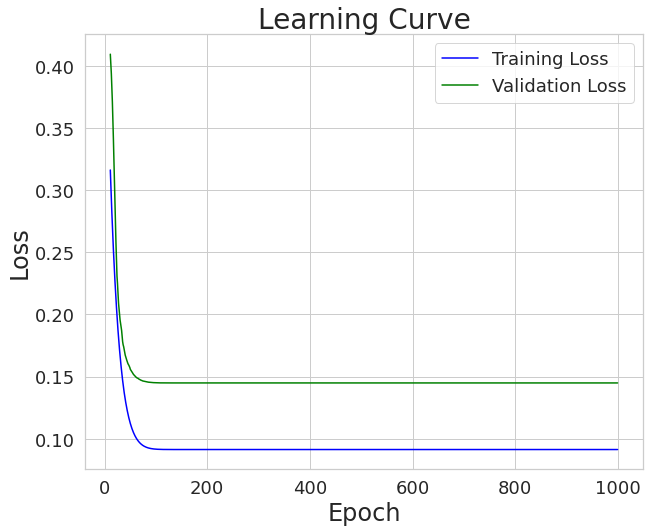

  0%|          | 0/1 [00:00<?, ?it/s]

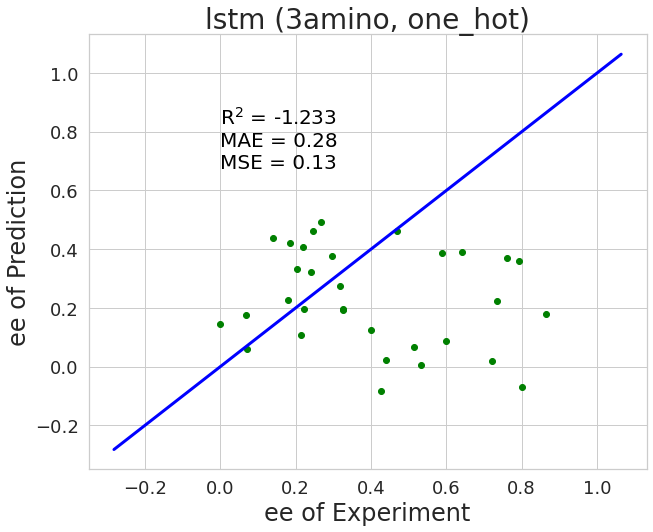

  0%|          | 0/250 [00:00<?, ?it/s]

[['QQQ', 0.8053], ['MMQ', 0.8006], ['MQQ', 0.7979], ['QQM', 0.7951], ['QMQ', 0.7941], ['MQM', 0.7895], ['IQQ', 0.7779], ['DMQ', 0.7682], ['PSS', 0.7681], ['WQQ', 0.7666], ['WMQ', 0.7659], ['PQQ', 0.7637], ['SSS', 0.7611], ['QIQ', 0.7515], ['TQQ', 0.7346], ['IMQ', 0.733], ['SSN', 0.7302], ['LQQ', 0.7299], ['TQM', 0.7265], ['QWQ', 0.7261], ['PMQ', 0.7249], ['DQQ', 0.7232], ['QMM', 0.7194], ['MIQ', 0.7186], ['HQQ', 0.7179], ['PSN', 0.7171], ['TMQ', 0.7141], ['MWQ', 0.7116], ['WQM', 0.7084], ['HMQ', 0.7069], ['NQQ', 0.7065], ['DQM', 0.7047], ['GQQ', 0.7037], ['WWQ', 0.7029], ['WIQ', 0.6981], ['SNS', 0.6969], ['IQM', 0.6966], ['SQQ', 0.6966], ['PNS', 0.6957], ['QLQ', 0.6952], ['NSS', 0.6942], ['VSS', 0.6933], ['NMQ', 0.6925], ['PQM', 0.6913], ['TSS', 0.6893], ['YMQ', 0.6885], ['QQW', 0.6884], ['IIQ', 0.6881], ['DWQ', 0.6874], ['TSN', 0.6865]]


In [426]:
model_label = "lstm" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='one_hot' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

In [428]:
predict_dfs.keys()

dict_keys(['cnn (sequence, all)', 'cnn (3amino, all)', 'lstm (sequence, all)', 'lstm (3amino, all)', 'cnn (sequence, pssm)', 'cnn (3amino, pssm)', 'lstm (sequence, pssm)', 'lstm (3amino, pssm)', 'cnn (sequence, one_hot)', 'cnn (3amino, one_hot)', 'lstm (sequence, one_hot)', 'lstm (3amino, one_hot)'])

### desc_flag='AAIndex'

Eopch    1: Total train_MSE: 0.070379 Total train_RMSE: 0.265290
Eopch    1: Total val_MSE: 0.069217 Total val_RMSE: 0.263090
Eopch    2: Total train_MSE: 0.070935 Total train_RMSE: 0.266336
Eopch    2: Total val_MSE: 0.054451 Total val_RMSE: 0.233347
Eopch    3: Total train_MSE: 0.070426 Total train_RMSE: 0.265379
Eopch    3: Total val_MSE: 0.054632 Total val_RMSE: 0.233735
Eopch    4: Total train_MSE: 0.070536 Total train_RMSE: 0.265586
Eopch    4: Total val_MSE: 0.053855 Total val_RMSE: 0.232067
Eopch    5: Total train_MSE: 0.070286 Total train_RMSE: 0.265115
Eopch    5: Total val_MSE: 0.054004 Total val_RMSE: 0.232387
Eopch    6: Total train_MSE: 0.070375 Total train_RMSE: 0.265283
Eopch    6: Total val_MSE: 0.053875 Total val_RMSE: 0.232110
Eopch    7: Total train_MSE: 0.070195 Total train_RMSE: 0.264943
Eopch    7: Total val_MSE: 0.053995 Total val_RMSE: 0.232367
Eopch    8: Total train_MSE: 0.070228 Total train_RMSE: 0.265006
Eopch    8: Total val_MSE: 0.053904 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   21: Total train_MSE: 0.069576 Total train_RMSE: 0.263774
Eopch   21: Total val_MSE: 0.053901 Total val_RMSE: 0.232165
Eopch   22: Total train_MSE: 0.069533 Total train_RMSE: 0.263690
Eopch   22: Total val_MSE: 0.053895 Total val_RMSE: 0.232153
Eopch   23: Total train_MSE: 0.069489 Total train_RMSE: 0.263608
Eopch   23: Total val_MSE: 0.053891 Total val_RMSE: 0.232144
Eopch   24: Total train_MSE: 0.069447 Total train_RMSE: 0.263528
Eopch   24: Total val_MSE: 0.053886 Total val_RMSE: 0.232134
Eopch   25: Total train_MSE: 0.069407 Total train_RMSE: 0.263451
Eopch   25: Total val_MSE: 0.053882 Total val_RMSE: 0.232125
Eopch   26: Total train_MSE: 0.069370 Total train_RMSE: 0.263382
Eopch   26: Total val_MSE: 0.053876 Total val_RMSE: 0.232113
Eopch   27: Total train_MSE: 0.069331 Total train_RMSE: 0.263308
Eopch   27: Total val_MSE: 0.053873 Total val_RMSE: 0.232106
Eopch   28: Total train_MSE: 0.069294 Total train_RMSE: 0.263238
Eopch   28: Total val_MSE: 0.053868 Total val_RMSE: 0

Eopch   88: Total train_MSE: 0.068326 Total train_RMSE: 0.261392
Eopch   88: Total val_MSE: 0.053767 Total val_RMSE: 0.231877
Eopch   89: Total train_MSE: 0.068324 Total train_RMSE: 0.261388
Eopch   89: Total val_MSE: 0.053767 Total val_RMSE: 0.231877
Eopch   90: Total train_MSE: 0.068322 Total train_RMSE: 0.261384
Eopch   90: Total val_MSE: 0.053767 Total val_RMSE: 0.231877
Eopch   91: Total train_MSE: 0.068320 Total train_RMSE: 0.261381
Eopch   91: Total val_MSE: 0.053767 Total val_RMSE: 0.231877
Eopch   92: Total train_MSE: 0.068318 Total train_RMSE: 0.261378
Eopch   92: Total val_MSE: 0.053767 Total val_RMSE: 0.231876
Eopch   93: Total train_MSE: 0.068317 Total train_RMSE: 0.261375
Eopch   93: Total val_MSE: 0.053767 Total val_RMSE: 0.231876
Eopch   94: Total train_MSE: 0.068316 Total train_RMSE: 0.261373
Eopch   94: Total val_MSE: 0.053767 Total val_RMSE: 0.231876
Eopch   95: Total train_MSE: 0.068314 Total train_RMSE: 0.261370
Eopch   95: Total val_MSE: 0.053767 Total val_RMSE: 0

Eopch  159: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  160: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  160: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  161: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  161: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  162: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  162: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  163: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  163: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  164: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  164: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  165: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  165: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  166: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  166: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  167: Total train_MSE: 0.068302 Total train_RMSE: 0

Eopch  231: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  231: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  232: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  232: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  233: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  233: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  234: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  234: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  235: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  235: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  236: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  236: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  237: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  237: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  238: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  238: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  302: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  302: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  303: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  303: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  304: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  304: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  305: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  305: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  306: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  306: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  307: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  307: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  308: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  308: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  309: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  309: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  372: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  373: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  373: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  374: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  374: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  375: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  375: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  376: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  376: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  377: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  377: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  378: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  378: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  379: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  379: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  380: Total train_MSE: 0.068302 Total train_RMSE: 0

Eopch  444: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  444: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  445: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  445: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  446: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  446: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  447: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  447: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  448: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  448: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  449: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  449: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  450: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  450: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  451: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  451: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  515: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  516: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  516: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  517: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  517: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  518: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  518: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  519: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  519: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  520: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  520: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  521: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  521: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  522: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  522: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  523: Total train_MSE: 0.068302 Total train_RMSE: 0

Eopch  587: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  587: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  588: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  588: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  589: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  589: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  590: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  590: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  591: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  591: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  592: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  592: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  593: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  593: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  594: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  594: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  659: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  659: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  660: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  660: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  661: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  661: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  662: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  662: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  663: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  663: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  664: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  664: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  665: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  665: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  666: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  666: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  729: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  729: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  730: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  730: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  731: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  731: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  732: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  732: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  733: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  733: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  734: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  734: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  735: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  735: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  736: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  736: Total val_MSE: 0.053766 Total val_RMSE: 0

Eopch  800: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  801: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  801: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  802: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  802: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  803: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  803: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  804: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  804: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  805: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  805: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  806: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  806: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  807: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  807: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  808: Total train_MSE: 0.068302 Total train_RMSE: 0

Eopch  871: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  872: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  872: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  873: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  873: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  874: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  874: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  875: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  875: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  876: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  876: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  877: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  877: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  878: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  878: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  879: Total train_MSE: 0.068302 Total train_RMSE: 0

Eopch  943: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  943: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  944: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  944: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  945: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  945: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  946: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  946: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  947: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  947: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  948: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  948: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  949: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  949: Total val_MSE: 0.053766 Total val_RMSE: 0.231875
Eopch  950: Total train_MSE: 0.068302 Total train_RMSE: 0.261346
Eopch  950: Total val_MSE: 0.053766 Total val_RMSE: 0

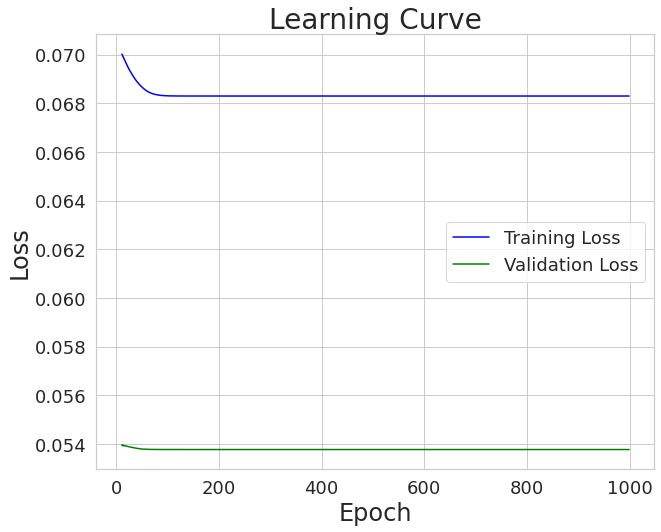

  0%|          | 0/1 [00:00<?, ?it/s]

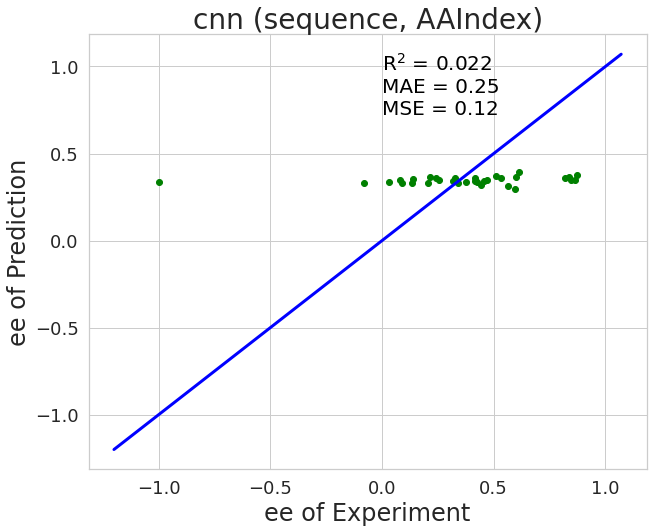

  0%|          | 0/250 [00:00<?, ?it/s]

[['YQL', 0.4161], ['KQL', 0.4155], ['YTL', 0.4137], ['YCL', 0.4133], ['YSL', 0.4131], ['KTL', 0.4131], ['KCL', 0.4127], ['KSL', 0.4125], ['YML', 0.4117], ['KML', 0.4111], ['WQL', 0.4107], ['EQL', 0.4102], ['PQL', 0.4093], ['RQL', 0.4087], ['YLL', 0.4086], ['WTL', 0.4083], ['KLL', 0.408], ['WCL', 0.4078], ['ETL', 0.4078], ['WSL', 0.4077], ['ECL', 0.4074], ['ESL', 0.4072], ['DQL', 0.4072], ['YGL', 0.4071], ['PTL', 0.4069], ['KGL', 0.4065], ['PCL', 0.4065], ['PSL', 0.4063], ['RTL', 0.4063], ['WML', 0.4063], ['RCL', 0.4059], ['EML', 0.4058], ['RSL', 0.4057], ['YNL', 0.4049], ['YEL', 0.4049], ['PML', 0.4049], ['KEL', 0.4043], ['RML', 0.4043], ['DTL', 0.4043], ['KNL', 0.4042], ['YMM', 0.4039], ['DCL', 0.4038], ['DSL', 0.4037], ['KMM', 0.4033], ['WLL', 0.4032], ['HQL', 0.403], ['ELL', 0.4027], ['DML', 0.4022], ['YAL', 0.4022], ['YHL', 0.402]]


In [430]:
model_label = "cnn" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='AAIndex' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=210)

Eopch    1: Total train_MSE: 1.952082 Total train_RMSE: 1.397169
Eopch    1: Total val_MSE: 1.688082 Total val_RMSE: 1.299262
Eopch    2: Total train_MSE: 1.885823 Total train_RMSE: 1.373253
Eopch    2: Total val_MSE: 1.636498 Total val_RMSE: 1.279257
Eopch    3: Total train_MSE: 1.821003 Total train_RMSE: 1.349445
Eopch    3: Total val_MSE: 1.606398 Total val_RMSE: 1.267438
Eopch    4: Total train_MSE: 1.757708 Total train_RMSE: 1.325786
Eopch    4: Total val_MSE: 1.579812 Total val_RMSE: 1.256906
Eopch    5: Total train_MSE: 1.696031 Total train_RMSE: 1.302318
Eopch    5: Total val_MSE: 1.550893 Total val_RMSE: 1.245349
Eopch    6: Total train_MSE: 1.635769 Total train_RMSE: 1.278972
Eopch    6: Total val_MSE: 1.517562 Total val_RMSE: 1.231894
Eopch    7: Total train_MSE: 1.577173 Total train_RMSE: 1.255855
Eopch    7: Total val_MSE: 1.479056 Total val_RMSE: 1.216164
Eopch    8: Total train_MSE: 1.520188 Total train_RMSE: 1.232959
Eopch    8: Total val_MSE: 1.437016 Total val_RMSE: 1

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   23: Total train_MSE: 0.867080 Total train_RMSE: 0.931171
Eopch   23: Total val_MSE: 0.823626 Total val_RMSE: 0.907538
Eopch   24: Total train_MSE: 0.836244 Total train_RMSE: 0.914464
Eopch   24: Total val_MSE: 0.793550 Total val_RMSE: 0.890814
Eopch   25: Total train_MSE: 0.806711 Total train_RMSE: 0.898171
Eopch   25: Total val_MSE: 0.764611 Total val_RMSE: 0.874420
Eopch   26: Total train_MSE: 0.778507 Total train_RMSE: 0.882331
Eopch   26: Total val_MSE: 0.736996 Total val_RMSE: 0.858485
Eopch   27: Total train_MSE: 0.751653 Total train_RMSE: 0.866979
Eopch   27: Total val_MSE: 0.710555 Total val_RMSE: 0.842944
Eopch   28: Total train_MSE: 0.726039 Total train_RMSE: 0.852079
Eopch   28: Total val_MSE: 0.685452 Total val_RMSE: 0.827920
Eopch   29: Total train_MSE: 0.701623 Total train_RMSE: 0.837629
Eopch   29: Total val_MSE: 0.661439 Total val_RMSE: 0.813289
Eopch   30: Total train_MSE: 0.678340 Total train_RMSE: 0.823614
Eopch   30: Total val_MSE: 0.638598 Total val_RMSE: 0

Eopch   98: Total val_MSE: 0.259167 Total val_RMSE: 0.509084
Eopch   99: Total train_MSE: 0.291464 Total train_RMSE: 0.539874
Eopch   99: Total val_MSE: 0.258991 Total val_RMSE: 0.508911
Eopch  100: Total train_MSE: 0.291298 Total train_RMSE: 0.539721
Eopch  100: Total val_MSE: 0.258830 Total val_RMSE: 0.508754
Eopch  101: Total train_MSE: 0.291148 Total train_RMSE: 0.539581
Eopch  101: Total val_MSE: 0.258686 Total val_RMSE: 0.508612
Eopch  102: Total train_MSE: 0.291012 Total train_RMSE: 0.539455
Eopch  102: Total val_MSE: 0.258554 Total val_RMSE: 0.508482
Eopch  103: Total train_MSE: 0.290889 Total train_RMSE: 0.539341
Eopch  103: Total val_MSE: 0.258436 Total val_RMSE: 0.508366
Eopch  104: Total train_MSE: 0.290778 Total train_RMSE: 0.539238
Eopch  104: Total val_MSE: 0.258329 Total val_RMSE: 0.508261
Eopch  105: Total train_MSE: 0.290677 Total train_RMSE: 0.539145
Eopch  105: Total val_MSE: 0.258232 Total val_RMSE: 0.508166
Eopch  106: Total train_MSE: 0.290586 Total train_RMSE: 0

Eopch  169: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  169: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  170: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  170: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  171: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  171: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  172: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  172: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  173: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  173: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  174: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  174: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  175: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  175: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  176: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  176: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  239: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  239: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  240: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  240: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  241: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  241: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  242: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  242: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  243: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  243: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  244: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  244: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  245: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  245: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  246: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  246: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  309: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  309: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  310: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  310: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  311: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  311: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  312: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  312: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  313: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  313: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  314: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  314: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  315: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  315: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  316: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  316: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  379: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  379: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  380: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  380: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  381: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  381: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  382: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  382: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  383: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  383: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  384: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  384: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  385: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  385: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  386: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  386: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  447: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  447: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  448: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  448: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  449: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  449: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  450: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  450: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  451: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  451: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  452: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  452: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  453: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  453: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  454: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  454: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  515: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  515: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  516: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  516: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  517: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  517: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  518: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  518: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  519: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  519: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  520: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  520: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  521: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  521: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  522: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  522: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  582: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  582: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  583: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  583: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  584: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  584: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  585: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  585: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  586: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  586: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  587: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  587: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  588: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  588: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  589: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  589: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  648: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  648: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  649: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  649: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  650: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  650: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  651: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  651: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  652: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  652: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  653: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  653: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  654: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  654: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  655: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  655: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  714: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  714: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  715: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  715: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  716: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  716: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  717: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  717: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  718: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  718: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  719: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  719: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  720: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  720: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  721: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  721: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  780: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  780: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  781: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  781: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  782: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  782: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  783: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  783: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  784: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  784: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  785: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  785: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  786: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  786: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  787: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  787: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  846: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  846: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  847: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  847: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  848: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  848: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  849: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  849: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  850: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  850: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  851: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  851: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  852: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  852: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  853: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  853: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  913: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  913: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  914: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  914: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  915: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  915: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  916: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  916: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  917: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  917: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  918: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  918: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  919: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  919: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  920: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  920: Total val_MSE: 0.257414 Total val_RMSE: 0

Eopch  980: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  980: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  981: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  981: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  982: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  982: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  983: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  983: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  984: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  984: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  985: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  985: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  986: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  986: Total val_MSE: 0.257414 Total val_RMSE: 0.507360
Eopch  987: Total train_MSE: 0.289822 Total train_RMSE: 0.538352
Eopch  987: Total val_MSE: 0.257414 Total val_RMSE: 0

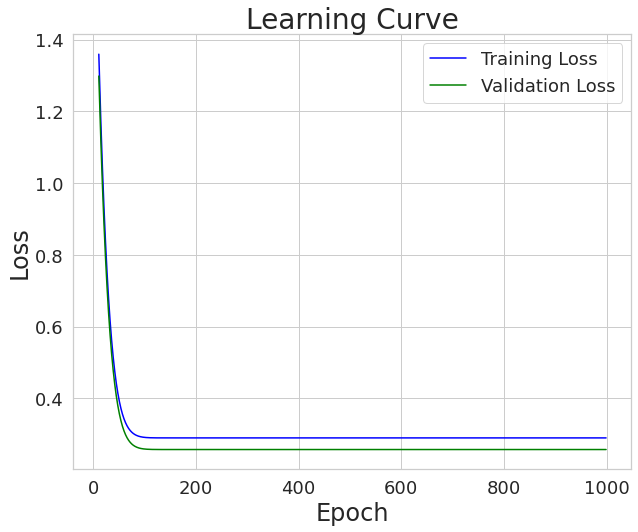

  0%|          | 0/1 [00:00<?, ?it/s]

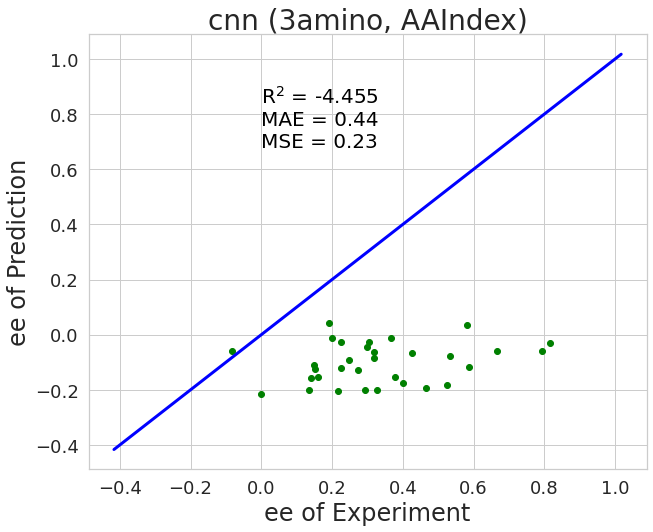

  0%|          | 0/250 [00:00<?, ?it/s]

[['ECL', 0.1009], ['GCL', 0.0897], ['VCL', 0.0862], ['VML', 0.0821], ['QCL', 0.079], ['EWL', 0.0786], ['VLL', 0.0781], ['LLL', 0.0776], ['KCL', 0.0766], ['RCL', 0.0764], ['HCL', 0.0733], ['EYL', 0.073], ['EPL', 0.0693], ['ECM', 0.0692], ['EQL', 0.0684], ['ILL', 0.0683], ['EHL', 0.0678], ['VCM', 0.0673], ['ESL', 0.067], ['EIL', 0.0665], ['ETL', 0.0661], ['EKL', 0.0655], ['DCL', 0.0654], ['TCL', 0.065], ['VMM', 0.0639], ['EDL', 0.0639], ['MLL', 0.0634], ['LLM', 0.063], ['GCM', 0.063], ['GQL', 0.063], ['AWL', 0.0628], ['CLL', 0.0622], ['NCL', 0.0618], ['VCF', 0.0617], ['EML', 0.0617], ['GHL', 0.0614], ['GML', 0.0613], ['GSL', 0.0612], ['VLM', 0.0605], ['QCM', 0.0602], ['SCL', 0.06], ['LML', 0.0596], ['CML', 0.0591], ['VPL', 0.0589], ['EVL', 0.0587], ['VWL', 0.0586], ['IML', 0.0579], ['ACL', 0.0575], ['ENL', 0.0569], ['EEL', 0.0569]]


In [432]:
model_label = "cnn" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='AAIndex' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=30)

Eopch    1: Total train_MSE: 0.207062 Total train_RMSE: 0.455041
Eopch    1: Total val_MSE: 0.194067 Total val_RMSE: 0.440530
Eopch    2: Total train_MSE: 0.199161 Total train_RMSE: 0.446274
Eopch    2: Total val_MSE: 0.192188 Total val_RMSE: 0.438393
Eopch    3: Total train_MSE: 0.191534 Total train_RMSE: 0.437646
Eopch    3: Total val_MSE: 0.190706 Total val_RMSE: 0.436700
Eopch    4: Total train_MSE: 0.183923 Total train_RMSE: 0.428863
Eopch    4: Total val_MSE: 0.189575 Total val_RMSE: 0.435402
Eopch    5: Total train_MSE: 0.176474 Total train_RMSE: 0.420088
Eopch    5: Total val_MSE: 0.188570 Total val_RMSE: 0.434247
Eopch    6: Total train_MSE: 0.169349 Total train_RMSE: 0.411520
Eopch    6: Total val_MSE: 0.188082 Total val_RMSE: 0.433685
Eopch    7: Total train_MSE: 0.162590 Total train_RMSE: 0.403225
Eopch    7: Total val_MSE: 0.187873 Total val_RMSE: 0.433443
Eopch    8: Total train_MSE: 0.156202 Total train_RMSE: 0.395224
Eopch    8: Total val_MSE: 0.187671 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   12: Total train_MSE: 0.134912 Total train_RMSE: 0.367304
Eopch   12: Total val_MSE: 0.186842 Total val_RMSE: 0.432252
Eopch   13: Total train_MSE: 0.130676 Total train_RMSE: 0.361492
Eopch   13: Total val_MSE: 0.186555 Total val_RMSE: 0.431920
Eopch   14: Total train_MSE: 0.126839 Total train_RMSE: 0.356144
Eopch   14: Total val_MSE: 0.185809 Total val_RMSE: 0.431056
Eopch   15: Total train_MSE: 0.123266 Total train_RMSE: 0.351093
Eopch   15: Total val_MSE: 0.186252 Total val_RMSE: 0.431570
Eopch   16: Total train_MSE: 0.120029 Total train_RMSE: 0.346452
Eopch   16: Total val_MSE: 0.185179 Total val_RMSE: 0.430324
Eopch   17: Total train_MSE: 0.117064 Total train_RMSE: 0.342147
Eopch   17: Total val_MSE: 0.183722 Total val_RMSE: 0.428628
Eopch   18: Total train_MSE: 0.114165 Total train_RMSE: 0.337883
Eopch   18: Total val_MSE: 0.181532 Total val_RMSE: 0.426065
Eopch   19: Total train_MSE: 0.111516 Total train_RMSE: 0.333940
Eopch   19: Total val_MSE: 0.178978 Total val_RMSE: 0

Eopch   80: Total train_MSE: 0.078588 Total train_RMSE: 0.280336
Eopch   80: Total val_MSE: 0.088694 Total val_RMSE: 0.297816
Eopch   81: Total train_MSE: 0.078565 Total train_RMSE: 0.280295
Eopch   81: Total val_MSE: 0.088334 Total val_RMSE: 0.297211
Eopch   82: Total train_MSE: 0.078539 Total train_RMSE: 0.280248
Eopch   82: Total val_MSE: 0.088502 Total val_RMSE: 0.297493
Eopch   83: Total train_MSE: 0.078517 Total train_RMSE: 0.280209
Eopch   83: Total val_MSE: 0.088312 Total val_RMSE: 0.297173
Eopch   84: Total train_MSE: 0.078499 Total train_RMSE: 0.280176
Eopch   84: Total val_MSE: 0.088129 Total val_RMSE: 0.296865
Eopch   85: Total train_MSE: 0.078479 Total train_RMSE: 0.280140
Eopch   85: Total val_MSE: 0.088110 Total val_RMSE: 0.296833
Eopch   86: Total train_MSE: 0.078463 Total train_RMSE: 0.280113
Eopch   86: Total val_MSE: 0.087946 Total val_RMSE: 0.296557
Eopch   87: Total train_MSE: 0.078448 Total train_RMSE: 0.280085
Eopch   87: Total val_MSE: 0.087786 Total val_RMSE: 0

Eopch  146: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  146: Total val_MSE: 0.086810 Total val_RMSE: 0.294636
Eopch  147: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  147: Total val_MSE: 0.086810 Total val_RMSE: 0.294635
Eopch  148: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  148: Total val_MSE: 0.086810 Total val_RMSE: 0.294635
Eopch  149: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  149: Total val_MSE: 0.086810 Total val_RMSE: 0.294635
Eopch  150: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  150: Total val_MSE: 0.086809 Total val_RMSE: 0.294634
Eopch  151: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  151: Total val_MSE: 0.086809 Total val_RMSE: 0.294634
Eopch  152: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  152: Total val_MSE: 0.086809 Total val_RMSE: 0.294634
Eopch  153: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  153: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  220: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  220: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  221: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  221: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  222: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  222: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  223: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  223: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  224: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  224: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  225: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  225: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  226: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  226: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  227: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  227: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  291: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  291: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  292: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  292: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  293: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  293: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  294: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  294: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  295: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  295: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  296: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  296: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  297: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  297: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  298: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  298: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  362: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  363: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  363: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  364: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  364: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  365: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  365: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  366: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  366: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  367: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  367: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  368: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  368: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  369: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  369: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  370: Total train_MSE: 0.078285 Total train_RMSE: 0

Eopch  433: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  433: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  434: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  434: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  435: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  435: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  436: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  436: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  437: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  437: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  438: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  438: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  439: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  439: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  440: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  440: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  504: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  504: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  505: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  505: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  506: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  506: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  507: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  507: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  508: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  508: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  509: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  509: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  510: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  510: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  511: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  511: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  575: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  575: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  576: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  576: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  577: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  577: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  578: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  578: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  579: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  579: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  580: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  580: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  581: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  581: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  582: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  582: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  647: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  647: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  648: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  648: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  649: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  649: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  650: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  650: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  651: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  651: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  652: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  652: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  653: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  653: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  654: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  654: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  719: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  719: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  720: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  720: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  721: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  721: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  722: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  722: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  723: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  723: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  724: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  724: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  725: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  725: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  726: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  726: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  790: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  790: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  791: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  791: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  792: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  792: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  793: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  793: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  794: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  794: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  795: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  795: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  796: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  796: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  797: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  797: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  862: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  862: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  863: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  863: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  864: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  864: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  865: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  865: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  866: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  866: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  867: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  867: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  868: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  868: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  869: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  869: Total val_MSE: 0.086809 Total val_RMSE: 0

Eopch  934: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  934: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  935: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  935: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  936: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  936: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  937: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  937: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  938: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  938: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  939: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  939: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  940: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  940: Total val_MSE: 0.086809 Total val_RMSE: 0.294633
Eopch  941: Total train_MSE: 0.078285 Total train_RMSE: 0.279795
Eopch  941: Total val_MSE: 0.086809 Total val_RMSE: 0

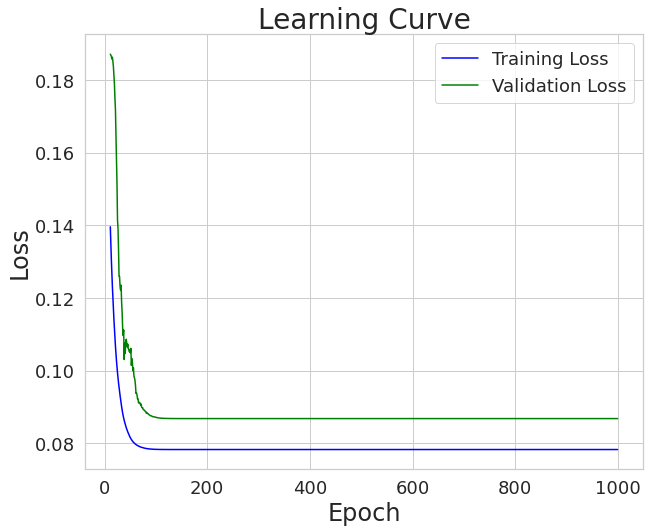

  0%|          | 0/1 [00:00<?, ?it/s]

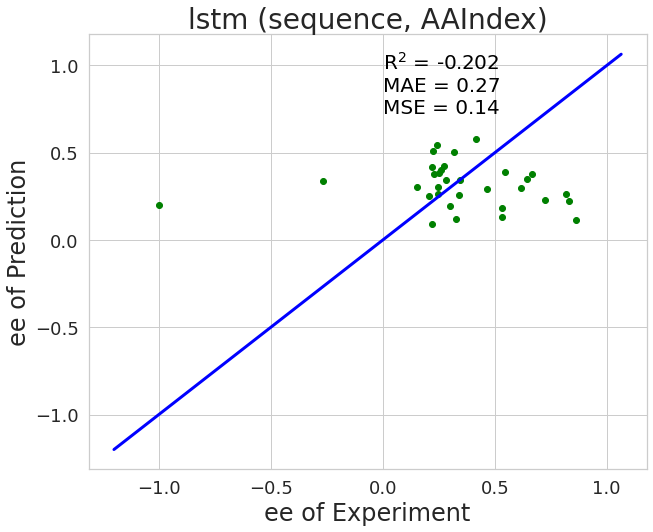

  0%|          | 0/250 [00:00<?, ?it/s]

[['ENS', 0.6597], ['VNS', 0.6588], ['QNS', 0.6588], ['GNS', 0.6587], ['RNS', 0.6587], ['HNS', 0.6585], ['ANS', 0.6585], ['TNS', 0.6584], ['KNS', 0.6582], ['DNS', 0.6581], ['NNS', 0.6578], ['SNS', 0.6571], ['INS', 0.6567], ['YNS', 0.6563], ['ESS', 0.6555], ['MNS', 0.6546], ['QSS', 0.6546], ['VSS', 0.6546], ['GSS', 0.6545], ['RSS', 0.6545], ['HSS', 0.6544], ['WNS', 0.6544], ['ASS', 0.6543], ['TSS', 0.6543], ['PNS', 0.6542], ['KSS', 0.654], ['FNS', 0.654], ['LNS', 0.654], ['DSS', 0.6539], ['NSS', 0.6536], ['CNS', 0.6535], ['SSS', 0.653], ['ISS', 0.6524], ['YSS', 0.6521], ['MSS', 0.6504], ['WSS', 0.6502], ['PSS', 0.65], ['FSS', 0.6498], ['LSS', 0.6497], ['ENN', 0.6495], ['CSS', 0.6493], ['VNN', 0.6486], ['QNN', 0.6485], ['RNN', 0.6484], ['GNN', 0.6484], ['ANN', 0.6483], ['HNN', 0.6483], ['TNN', 0.6482], ['KNN', 0.648], ['DNN', 0.6478]]


In [433]:
model_label = "lstm" # "cnn", "lstm"
charactor = "sequence" # "sequence", "3amino"
desc_flag='AAIndex' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

Eopch    1: Total train_MSE: 0.379984 Total train_RMSE: 0.616428
Eopch    1: Total val_MSE: 0.361160 Total val_RMSE: 0.600966
Eopch    2: Total train_MSE: 0.363307 Total train_RMSE: 0.602750
Eopch    2: Total val_MSE: 0.358253 Total val_RMSE: 0.598543
Eopch    3: Total train_MSE: 0.347836 Total train_RMSE: 0.589776
Eopch    3: Total val_MSE: 0.356435 Total val_RMSE: 0.597022
Eopch    4: Total train_MSE: 0.334007 Total train_RMSE: 0.577934
Eopch    4: Total val_MSE: 0.354869 Total val_RMSE: 0.595709
Eopch    5: Total train_MSE: 0.320660 Total train_RMSE: 0.566269
Eopch    5: Total val_MSE: 0.352936 Total val_RMSE: 0.594084
Eopch    6: Total train_MSE: 0.307945 Total train_RMSE: 0.554928
Eopch    6: Total val_MSE: 0.350411 Total val_RMSE: 0.591955
Eopch    7: Total train_MSE: 0.297671 Total train_RMSE: 0.545592
Eopch    7: Total val_MSE: 0.347584 Total val_RMSE: 0.589562
Eopch    8: Total train_MSE: 0.287872 Total train_RMSE: 0.536537
Eopch    8: Total val_MSE: 0.344615 Total val_RMSE: 0

<ipython-input-224-4eb09a9ecfc4>:34: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, ee)


Eopch   13: Total train_MSE: 0.243007 Total train_RMSE: 0.492958
Eopch   13: Total val_MSE: 0.325045 Total val_RMSE: 0.570127
Eopch   14: Total train_MSE: 0.234705 Total train_RMSE: 0.484464
Eopch   14: Total val_MSE: 0.317766 Total val_RMSE: 0.563708
Eopch   15: Total train_MSE: 0.226793 Total train_RMSE: 0.476228
Eopch   15: Total val_MSE: 0.309333 Total val_RMSE: 0.556177
Eopch   16: Total train_MSE: 0.219009 Total train_RMSE: 0.467984
Eopch   16: Total val_MSE: 0.298716 Total val_RMSE: 0.546549
Eopch   17: Total train_MSE: 0.211613 Total train_RMSE: 0.460014
Eopch   17: Total val_MSE: 0.285383 Total val_RMSE: 0.534212
Eopch   18: Total train_MSE: 0.204682 Total train_RMSE: 0.452418
Eopch   18: Total val_MSE: 0.274292 Total val_RMSE: 0.523729
Eopch   19: Total train_MSE: 0.198040 Total train_RMSE: 0.445017
Eopch   19: Total val_MSE: 0.262207 Total val_RMSE: 0.512061
Eopch   20: Total train_MSE: 0.191781 Total train_RMSE: 0.437928
Eopch   20: Total val_MSE: 0.248226 Total val_RMSE: 0

Eopch   82: Total train_MSE: 0.094618 Total train_RMSE: 0.307600
Eopch   82: Total val_MSE: 0.133531 Total val_RMSE: 0.365419
Eopch   83: Total train_MSE: 0.094531 Total train_RMSE: 0.307459
Eopch   83: Total val_MSE: 0.133514 Total val_RMSE: 0.365396
Eopch   84: Total train_MSE: 0.094454 Total train_RMSE: 0.307334
Eopch   84: Total val_MSE: 0.133488 Total val_RMSE: 0.365359
Eopch   85: Total train_MSE: 0.094387 Total train_RMSE: 0.307224
Eopch   85: Total val_MSE: 0.133409 Total val_RMSE: 0.365253
Eopch   86: Total train_MSE: 0.094323 Total train_RMSE: 0.307121
Eopch   86: Total val_MSE: 0.133352 Total val_RMSE: 0.365173
Eopch   87: Total train_MSE: 0.094261 Total train_RMSE: 0.307019
Eopch   87: Total val_MSE: 0.133269 Total val_RMSE: 0.365060
Eopch   88: Total train_MSE: 0.094205 Total train_RMSE: 0.306929
Eopch   88: Total val_MSE: 0.133232 Total val_RMSE: 0.365009
Eopch   89: Total train_MSE: 0.094157 Total train_RMSE: 0.306851
Eopch   89: Total val_MSE: 0.133156 Total val_RMSE: 0

Eopch  151: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  151: Total val_MSE: 0.132687 Total val_RMSE: 0.364263
Eopch  152: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  152: Total val_MSE: 0.132687 Total val_RMSE: 0.364263
Eopch  153: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  153: Total val_MSE: 0.132687 Total val_RMSE: 0.364263
Eopch  154: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  154: Total val_MSE: 0.132687 Total val_RMSE: 0.364263
Eopch  155: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  155: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  156: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  156: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  157: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  157: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  158: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  158: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  217: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  217: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  218: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  218: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  219: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  219: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  220: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  220: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  221: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  221: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  222: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  222: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  223: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  223: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  224: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  224: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  285: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  285: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  286: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  286: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  287: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  287: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  288: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  288: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  289: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  289: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  290: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  290: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  291: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  291: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  292: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  292: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  353: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  353: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  354: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  354: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  355: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  355: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  356: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  356: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  357: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  357: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  358: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  358: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  359: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  359: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  360: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  360: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  420: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  420: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  421: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  421: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  422: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  422: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  423: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  423: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  424: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  424: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  425: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  425: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  426: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  426: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  427: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  427: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  486: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  487: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  487: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  488: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  488: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  489: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  489: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  490: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  490: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  491: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  491: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  492: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  492: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  493: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  493: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  494: Total train_MSE: 0.093659 Total train_RMSE: 0

Eopch  552: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  552: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  553: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  553: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  554: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  554: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  555: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  555: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  556: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  556: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  557: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  557: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  558: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  558: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  559: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  559: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  620: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  620: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  621: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  621: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  622: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  622: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  623: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  623: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  624: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  624: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  625: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  625: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  626: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  626: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  627: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  627: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  687: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  687: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  688: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  688: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  689: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  689: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  690: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  690: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  691: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  691: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  692: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  692: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  693: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  693: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  694: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  694: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  754: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  754: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  755: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  755: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  756: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  756: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  757: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  757: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  758: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  758: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  759: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  759: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  760: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  760: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  761: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  761: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  822: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  822: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  823: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  823: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  824: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  824: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  825: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  825: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  826: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  826: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  827: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  827: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  828: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  828: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  829: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  829: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  890: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  890: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  891: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  891: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  892: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  892: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  893: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  893: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  894: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  894: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  895: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  895: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  896: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  896: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  897: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  897: Total val_MSE: 0.132687 Total val_RMSE: 0

Eopch  958: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  958: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  959: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  959: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  960: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  960: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  961: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  961: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  962: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  962: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  963: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  963: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  964: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  964: Total val_MSE: 0.132687 Total val_RMSE: 0.364262
Eopch  965: Total train_MSE: 0.093659 Total train_RMSE: 0.306038
Eopch  965: Total val_MSE: 0.132687 Total val_RMSE: 0

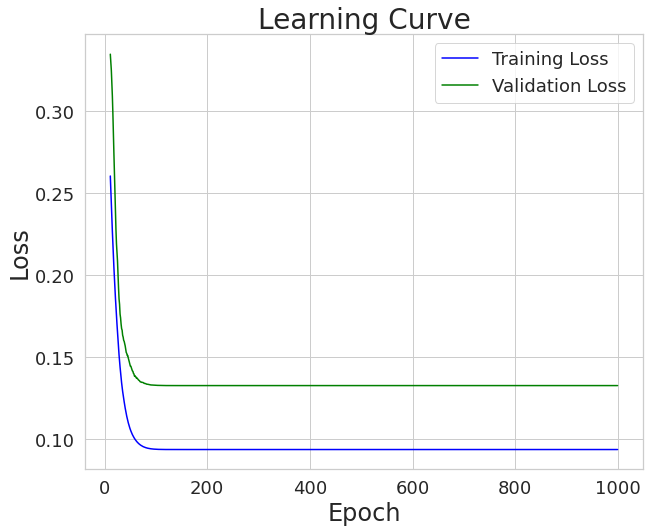

  0%|          | 0/1 [00:00<?, ?it/s]

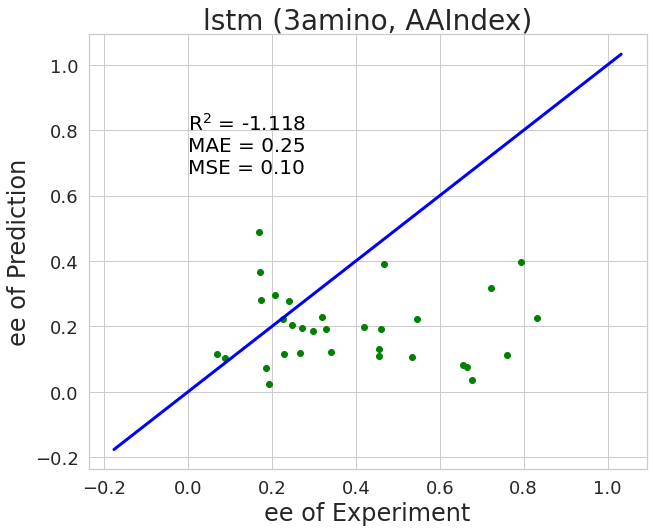

  0%|          | 0/250 [00:00<?, ?it/s]

[['EEE', 0.7356], ['NEE', 0.7354], ['GEE', 0.7343], ['DEE', 0.7311], ['EGE', 0.7282], ['QEE', 0.7164], ['ENE', 0.7107], ['REE', 0.7106], ['EDE', 0.7075], ['DGE', 0.7065], ['EEG', 0.7058], ['GGE', 0.7053], ['NGE', 0.7045], ['RGE', 0.6985], ['HEE', 0.6976], ['TEE', 0.692], ['DEG', 0.6919], ['ERE', 0.6918], ['NEG', 0.6913], ['HGE', 0.6903], ['QGE', 0.69], ['SEE', 0.6897], ['EQE', 0.6871], ['GNE', 0.6861], ['GDE', 0.6855], ['KGE', 0.6848], ['KNE', 0.683], ['GEG', 0.6827], ['DNE', 0.682], ['DDE', 0.6809], ['NNE', 0.6799], ['DRE', 0.6798], ['REG', 0.6796], ['GRE', 0.6795], ['NDE', 0.6791], ['KEE', 0.679], ['RNE', 0.6783], ['RDE', 0.6773], ['NRE', 0.676], ['ENG', 0.6718], ['HEG', 0.6709], ['EGG', 0.6708], ['TGE', 0.6689], ['QNE', 0.667], ['HNE', 0.6669], ['KEG', 0.6667], ['QDE', 0.6665], ['EDG', 0.6664], ['RRE', 0.6659], ['QEG', 0.6641]]


In [434]:
model_label = "lstm" # "cnn", "lstm"
charactor = "3amino" # "sequence", "3amino"
desc_flag='AAIndex' # 'all', 'pssm', 'one_hot', 'AAIndex'

predict_dfs = process(model_label, charactor, desc_flag, predict_dfs, conv_out_len=462)

In [435]:
predict_dfs.keys()

dict_keys(['cnn (sequence, all)', 'cnn (3amino, all)', 'lstm (sequence, all)', 'lstm (3amino, all)', 'cnn (sequence, pssm)', 'cnn (3amino, pssm)', 'lstm (sequence, pssm)', 'lstm (3amino, pssm)', 'cnn (sequence, one_hot)', 'cnn (3amino, one_hot)', 'lstm (sequence, one_hot)', 'lstm (3amino, one_hot)', 'cnn (sequence, AAIndex)', 'cnn (3amino, AAIndex)', 'lstm (sequence, AAIndex)', 'lstm (3amino, AAIndex)'])

In [ ]:
all_pred_df = pd.DataFrame()
for k, v in predict_dfs.items():
    all_pred_df[['%s_seq'%k]] = v.seq
    all_pred_df[['%s_predict_ee'%k]] = v.ee
    
all_pred_df.to_csv('processed/data/Prediction_of_CNN_LSTM.csv')
all_pred_df

In [ ]:
# Count the ranking of each sequence in the top50 of the prediction results of each selected model, 
# and select the sequence that enters the top50 in multiple models 

AAs_dict = dict()
# Removed the predictions of models with bad actual-predict trends 
drop_out_list = ['cnn (3amino, one_hot)', 'lstm (3amino, one_hot)',
                 'cnn (sequence, AAIndex)', 'cnn (3amino, AAIndex)', 
                 'lstm (3amino, AAIndex)']
for k, v in predict_dfs.items():
    if k not in drop_out_list:
        for i in range(len(v)):
            #print(v.seq[i])
            AAs_dict[v.seq[i]] = AAs_dict.get(v.seq[i], []) + [i]

AAs_dict

In [ ]:
AAs_dict2 = dict()
for k, v in AAs_dict.items():
    if len(AAs_dict[k])>1:
        AAs_dict2[k] = v
AAs_dict2

## end